<div style="display: flex; background-color: #16537e;">
    <h1 style="margin: auto; font-weight: bold; padding: 30px 30px 0px 30px; color:#fff;" align="center">Implémentez un modèle de scoring</h1>
</div>
<div style="display: flex; background-color: #16537e; margin: auto; padding: 5px 30px 0px 30px;" >
    <h2 style="width: 100%; text-align: center; float: left; font-size: 24px; color:#fff;" align="center">| Projet 7 : Modelling |</h2>
</div>

<div style="background-color: #16537e;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">1. Libraries and functions</h2>
</div>

<div style="background-color: #237ab8;" >
    <h3 style="margin: auto; padding: 15px; color:#fff; ">1.1 Libraries</h3>
</div>

In [112]:
import gc
import time
import timeit
import re
import warnings
from contextlib import contextmanager
from collections import Counter
import os
import pickle
import dill

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (train_test_split, StratifiedKFold, 
                                     HalvingGridSearchCV, cross_validate, RandomizedSearchCV,
                                     cross_val_predict, cross_val_score, RepeatedStratifiedKFold)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (precision_score, roc_auc_score, recall_score, 
                             f1_score, fbeta_score, confusion_matrix, roc_curve, 
                             PrecisionRecallDisplay, ConfusionMatrixDisplay,
                             classification_report, make_scorer)
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler 

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from hyperopt import tpe, hp, fmin, space_eval, STATUS_OK, Trials, SparkTrials 
from hyperopt.pyll.base import scope

import xgboost as xgb
import lightgbm as ltb

from lime import lime_tabular
import shap

from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

import mlflow
from mlflow import log_metric, log_param, log_artifacts

from collections import Counter
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import lime
import random
import shap
import pickle
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

warnings.simplefilter(action='ignore', category=FutureWarning)

<div style="background-color: #237ab8;" >
    <h3 style="margin: auto; padding: 15px; color:#fff; ">1.2 Functions</h3>
</div>

In [23]:
# Function to log model to mlflow
def log_mlflow(model, name, custom_score, n_estimator=None, max_depth=None, auc_score=None, f1_score=None, acc_score=None,
               train_class_0=None, train_class_1=None):

    # Track params and metrics 
    with mlflow.start_run():
        # Set run name
        mlflow.set_tag("mlflow.runName", name)

        # Set parameters
        mlflow.log_param("n_estimators", n_estimator)
        mlflow.log_param("max_depth", max_depth)
        mlflow.log_param("train_class_0", train_class_0)
        mlflow.log_param("train_class_1", train_class_1)

        # Set metrics
        mlflow.log_metric("Custom score", custom_score)
        mlflow.log_metric("AUC", auc_score)
        mlflow.log_metric("F1", f1_score)
        mlflow.log_metric("Accuracy", acc_score)

        # Save model to artifacts
        mlflow.sklearn.log_model(model, name)

    mlflow.end_run()

In [15]:
# Function to display confusion matrix
def display_confusion_matrix(y_test, y_pred, model_name="Model"):
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Repaid", "No repaid"])
    plt.title(model_name + ": Confusion matrix")
    plt.grid(visible=None)
    plt.show()

In [16]:
def fc_business_score(y_true, y_pred):

    mat_conf = confusion_matrix(y_true, y_pred)
    
    # Nombre de True Negatifs
    TP = mat_conf[0, 0]
    # Nombre de Faux Négatifs
    FN = mat_conf[1, 0]
    # Nombre de Faux Positifs
    FP = mat_conf[0, 1]
    # Nombre de True Positifs
    TN = mat_conf[1, 1]
    
    TN_rate = 1        # Loans that are not in default and were predicted correctly
    TP_rate = 1        # Loans that are in default and were predicted correctly
    FP_rate = -1        # Loans that are not in default and were predicted incorrectly
    FN_rate = -10      # Loans that are in default and were were predicted incorrectly
    

    # Total of default and not default cases
    total_not_default = TN + FP     # Not default cases
    total_default = TP + FN         # Default cases 
    
    gain_total = TN*TN_rate + TP*TP_rate + FP*FP_rate + FN*FN_rate
    gain_maximun = total_not_default*TN_rate + total_default*TP_rate
    gain_minumun = total_not_default*TN_rate + total_default*FN_rate
    
    # normalize to get score between 0 (baseline) and 1
    score = float((gain_total - gain_minumun) / (gain_maximun - gain_minumun))
    
    return score

In [43]:
def scree_plot():
    from matplotlib.pyplot import figure, show
    import matplotlib.pyplot as plt
    from matplotlib.ticker import MaxNLocator

    ax = figure().gca()
    ax.plot(pca.explained_variance_)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('Principal Component')
    plt.ylabel('Eigenvalue')
    plt.axhline(y=1, linewidth=1, color='r', alpha=0.5)
    plt.title('Scree Plot of PCA: Component Eigenvalues')
    show()

In [44]:
def var_explained():
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.pyplot import figure, show
    from matplotlib.ticker import MaxNLocator

    ax = figure().gca()
    ax.plot(np.cumsum(pca.explained_variance_ratio_))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.axvline(x=1, linewidth=1, color='r', alpha=0.5)
    plt.title('Explained Variance of PCA by Component')
    show()

<div style="background-color: #16537e;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">2. Model selection</h2>
</div>

<div style="background-color: #237ab8;" >
    <h3 style="margin: auto; padding: 15px; color:#fff; ">2.1 Charging data</h3>
</div>

In [3]:
dataset_target = pd.read_csv("dataset_target.csv")
dataset_target

SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0           100002       1            0             0                0   
1           100003       0            1             0                1   
2           100004       0            0             1                0   
3           100006       0            1             0                0   
4           100007       0            0             0                0   
...            ...     ...          ...           ...              ...   
307502      456251       0            0             0                1   
307503      456252       0            1             0                0   
307504      456253       0            1             0                0   
307505      456254       1            1             0                0   
307506      456255       0            1             0                1   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                  0          202500.0    406597.5      24700.5   
1                  0          270000.0   1293502.5      35698.5   
2                  0           67500.0    135000.0       6750.0   
3                  0          135000.0    312682.5      29686.5   
4                  0          121500.0    513000.0      21865.5   
...              ...               ...         ...          ...   
307502             0          157500.0    254700.0      27558.0   
307503             0           72000.0    269550.0      12001.5   
307504             0          153000.0    677664.0      29979.0   
307505             0          171000.0    370107.0      20205.0   
307506             0          157500.0    675000.0      49117.5   

        REGION_POPULATION_RELATIVE  ...  INSTAL_PAYMENT_PERC_MEAN  \
0                         0.018801  ...                  1.000000   
1                         0.003541  ...                  1.000000   
2                         0.010032  ...                  1.000000   
3                         0.008019  ...                  1.000000   
4                         0.028663  ...                  0.954545   
...                            ...  ...                       ...   
307502                    0.032561  ...                  1.000000   
307503                    0.025164  ...                  1.000000   
307504                    0.005002  ...                  0.928571   
307505                    0.005313  ...                  1.000000   
307506                    0.046220  ...                  1.033463   

        INSTAL_PAYMENT_DIFF_MAX  INSTAL_PAYMENT_DIFF_MEAN  \
0                         0.000                    0.0000   
1                         0.000                    0.0000   
2                         0.000                    0.0000   
3                         0.000                    0.0000   
4                     22655.654                  452.3843   
...                         ...                       ...   
307502                    0.000                    0.0000   
307503                    0.000                    0.0000   
307504                 3945.825                  283.7925   
307505                    0.000                    0.0000   
307506                28641.150                -6181.5024   

        INSTAL_PAYMENT_DIFF_SUM  INSTAL_PAYMENT_DIFF_VAR  \
0                         0.000             0.000000e+00   
1                         0.000             0.000000e+00   
2                         0.000             0.000000e+00   
3                         0.000             0.000000e+00   
4                     29857.365             8.084830e+06   
...                         ...                      ...   
307502                    0.000             0.000000e+00   
307503                    0.000             0.000000e+00   
307504                 3973.095             1.110980e+06   
307505                    0.000             0.000000e+00   
307506              -457431.160             5.256336e+09   

        INSTAL_AMT_INSTALMENT_M

In [4]:
dataset_predict = pd.read_csv("dataset_predict.csv")
dataset_predict

SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0          100001     NaN            1             0                0   
1          100005     NaN            0             0                0   
2          100013     NaN            0             1                0   
3          100028     NaN            1             0                0   
4          100038     NaN            0             1                1   
...           ...     ...          ...           ...              ...   
48739      456221     NaN            1             0                0   
48740      456222     NaN            1             0                1   
48741      456223     NaN            1             1                0   
48742      456224     NaN            0             0                1   
48743      456250     NaN            1             1                1   

       CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                 0          135000.0    568800.0      20560.5   
1                 0           99000.0    222768.0      17370.0   
2                 0          202500.0    663264.0      69777.0   
3                 2          315000.0   1575000.0      49018.5   
4                 1          180000.0    625500.0      32067.0   
...             ...               ...         ...          ...   
48739             0          121500.0    412560.0      17473.5   
48740             2          157500.0    622413.0      31909.5   
48741             1          202500.0    315000.0      33205.5   
48742             0          225000.0    450000.0      25128.0   
48743             0          135000.0    312768.0      24709.5   

       REGION_POPULATION_RELATIVE  ...  INSTAL_PAYMENT_DIFF_MEAN  \
0                        0.018850  ...                    0.0000   
1                        0.035792  ...                    0.0000   
2                        0.019101  ...                 1157.6627   
3                        0.026392  ...                  622.5507   
4                        0.010032  ...                    0.0000   
...                           ...  ...                       ...   
48739                    0.002042  ...                    0.0000   
48740                    0.035792  ...                  314.7146   
48741                    0.026392  ...                    0.0000   
48742                    0.018850  ...                    0.0000   
48743                    0.006629  ...                  193.0797   

       INSTAL_PAYMENT_DIFF_SUM  INSTAL_PAYMENT_DIFF_VAR  \
0                        0.000             0.000000e+00   
1                        0.000             0.000000e+00   
2                   179437.720             2.346772e+07   
3                    70348.230             2.972476e+06   
4                        0.000             0.000000e+00   
...                        ...                      ...   
48739                    0.000             0.000000e+00   
48740                22974.164             2.023069e+06   
48741                    0.000             0.000000e+00   
48742                    0.000             0.000000e+00   
48743                 9653.985             1.623749e+06   

       INSTAL_AMT_INSTALMENT_MAX  INSTAL_AMT_INSTALMENT_MEAN  \
0                      17397.900                   5885.1323   
1                      17656.244                   6240.2050   
2                     357347.750                  10897.8980   
3                      38988.540                   4979.2820   
4                      11100.600                  11100.3380   
...                          ...                         ...   
48739                 244664.500                  91036.4500   
48740                  14571.765                   8086.1620   
48741                  81184.010                  23158.9920   
48742                  23451.705                  17269.2340   
48743                  26474.625                  13238.0630   

       INSTAL_AMT_INSTALMENT_SUM  INSTAL_A

<div style="background-color: #237ab8;" >
    <h3 style="margin: auto; padding: 15px; color:#fff; ">2.2 MLFlow</h3>
</div>

In [5]:
# Create experiment
experiment_name = 'credit_scoring'
mlflow.set_experiment(experiment_name)
mlflow.end_run()

<div style="background-color: #237ab8;" >
    <h3 style="margin: auto; padding: 15px; color:#fff; ">2.3 Treating imbalanced data</h3>
</div>

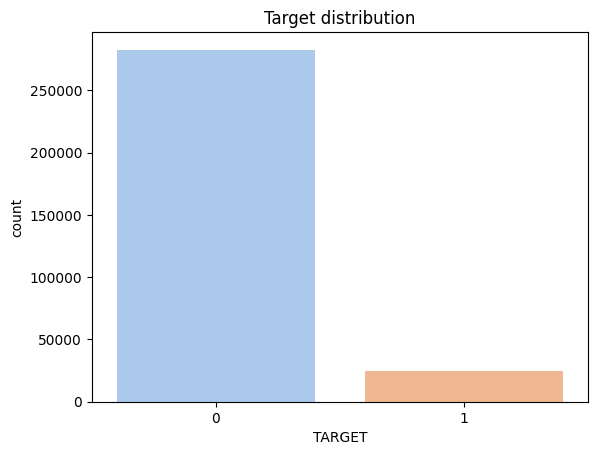

In [7]:
colors = sns.color_palette('pastel')[0:2]
sns.countplot(x='TARGET', data=dataset_target, palette=colors)
plt.title("Target distribution")
plt.show()

<div style="background-color: #237ab8;" >
    <h3 style="margin: auto; padding: 15px; color:#fff; ">2.3 Splitting balanced data</h3>
</div>

In [107]:
X = dataset_target
X = X.drop(columns=["TARGET", "SK_ID_CURR"])
y_target = dataset_target.loc[:,"TARGET"]

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y_target, test_size=0.20, stratify=y_target, random_state=42)

In [109]:
print("Training target:", Counter(y_train))
print("Testing target:", Counter(y_test))

Training target: Counter({0: 226145, 1: 19860})
Testing target: Counter({0: 56537, 1: 4965})


In [110]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 246005 entries, 195166 to 200335
Columns: 412 entries, CODE_GENDER to INSTAL_DAYS_ENTRY_PAYMENT_SUM
dtypes: bool(128), float64(246), int64(38)
memory usage: 564.9 MB


In [14]:
# Define oversampling and undersampling
over = SMOTE(sampling_strategy=0.5) # oversample to 1:2 ratio 
under = RandomUnderSampler(sampling_strategy=1) # undersample to 1:1 ratio

# Define pipeline
steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps=steps)

# Transform the dataset
X_res, y_res = pipeline.fit_resample(X_train, y_train)

print("Training target statistics:", Counter(y_res))
print("Testing target statistics:", Counter(y_test))

Training target statistics: Counter({0: 113072, 1: 113072})
Testing target statistics: Counter({0: 56537, 1: 4965})


<div style="background-color: #237ab8;" >
    <h3 style="margin: auto; padding: 15px; color:#fff; ">2.4 Baseline of different classifiers</h3>
</div>

Michaël vous fait part de sa vigilance dans l’élaboration du modèle, concernant deux points spécifiques au contexte métier : 

Le déséquilibre entre le nombre de bons et de moins bons clients doit être pris en compte pour élaborer un modèle pertinent, à l’aide d’au moins une méthode au choix

Le déséquilibre du coût métier entre un faux négatif (FN - mauvais client prédit bon client : donc crédit accordé et perte en capital) et un faux positif (FP - bon client prédit mauvais : donc refus crédit et manque à gagner en marge)

Vous pourrez supposer, par exemple, que le coût d’un FN est dix fois supérieur au coût d’un FP

Vous créerez un score “métier” (minimisation du coût d’erreur de prédiction des FN et FP) pour comparer les modèles, afin de choisir le meilleur modèle et ses meilleurs hyperparamètres. Attention cette minimisation du coût métier doit passer par l’optimisation du seuil qui détermine, à partir d’une probabilité, la classe 0 ou 1 (un “predict” suppose un seuil à 0.5 qui n’est pas forcément l’optimum)

En parallèle, maintenez pour comparaison et contrôle des mesures plus techniques, telles que l’AUC et l’accuracy 

In [17]:
classifiers = {
    "Dummy_Classifier" : DummyClassifier(strategy='stratified', random_state=42), 
    "Logistic_Regression" : LogisticRegression(random_state=42),
    "Random_Forest" : RandomForestClassifier(random_state=42),
    "XGBoost" : xgb.XGBClassifier(random_state=42),
    "LightGBM" : ltb.LGBMClassifier(random_state=42)
}

In [18]:
business_score = make_scorer(fc_business_score)

In [19]:
LIST_DURATION = []

for key, clf in classifiers.items():
    
    classifier = clf

    # Define the evaluation metrics you want to calculate
    scoring = {
        'accuracy': 'accuracy',
        'f1': 'f1_macro',
        'roc_auc': 'roc_auc',
        'business': business_score
    }
    
    # Perform 5-fold cross-validation with multiple metrics
    num_folds = 5
 
    start_time_model = timeit.default_timer()
    results = cross_validate(classifier, X_res, y_res, cv=num_folds, scoring=scoring)
    end_time_model = round(timeit.default_timer() - start_time_model, 3)
    LIST_DURATION.append(end_time_model)

    # Create a Pandas DataFrame from the results dictionary
    results_df = pd.DataFrame(results)

    # Calculate the mean of all scores for each metric
    globals()[key + "_mean_scores"] = results_df.mean()
    
    #Save logs
    if key == "Dummy_Classifier" or key == "Logistic_Regression":
        log_mlflow(classifier, key, auc_score=globals()[key + "_mean_scores"]["test_roc_auc"], 
                   custom_score=-globals()[key + "_mean_scores"]["test_business"],
        f1_score=globals()[key + "_mean_scores"]["test_f1"], 
        acc_score=globals()[key + "_mean_scores"]["test_accuracy"],
        train_class_0=Counter(y_res)[0], train_class_1=Counter(y_res)[1])
   
    else:
        clf_params = classifier.get_params()
        log_mlflow(classifier, key,
                   custom_score=-globals()[key + "_mean_scores"]["test_business"],
                   auc_score=globals()[key + "_mean_scores"]["test_roc_auc"],
                   f1_score=globals()[key + "_mean_scores"]["test_f1"], 
                   acc_score=globals()[key + "_mean_scores"]["test_accuracy"],
                   n_estimator=clf_params['n_estimators'],
                   max_depth=clf_params['max_depth'], 
                   train_class_0=Counter(y_res)[0],
                   train_class_1=Counter(y_res)[1])

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
Setuptools is replacing distutils.
Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
Setuptools is replacing distutils.
Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable beh

[LightGBM] [Info] Number of positive: 90458, number of negative: 90457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.559922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58836
[LightGBM] [Info] Number of data points in the train set: 180915, number of used features: 383
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500003 -> initscore=0.000011
[LightGBM] [Info] Start training from score 0.000011
[LightGBM] [Info] Number of positive: 90458, number of negative: 90457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.459660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58684
[LightGBM] [Info] Number of data points in the train set: 180915, number of used features: 384
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500003 -> initscore=0.000011
[LightGBM] [Info] Start training from score 0.000011
[LightGBM]

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
Setuptools is replacing distutils.


In [ ]:
for key, clf in classifiers.items():
    globals()[key + "_mean_scores"] = globals()[key + "_mean_scores"].to_frame()
    globals()[key + "_mean_scores"] = globals()[key + "_mean_scores"].T
    globals()[key + "_mean_scores"].insert(0, 'Model', key)

In [24]:
dfs = []
for key, clf in classifiers.items():
    dfs.append(globals()[key + "_mean_scores"])
result = pd.concat(dfs, ignore_index=True)
result["test_business"] = abs(result["test_business"])

In [25]:
result

Model    fit_time  score_time  test_accuracy   test_f1  \
0     Dummy_Classifier    0.653476    0.085109       0.500606  0.500606   
1  Logistic_Regression    5.080963    0.801053       0.500000  0.333333   
2        Random_Forest  601.664673    6.129123       0.899184  0.882144   
3              XGBoost   31.286219    4.355382       0.895142  0.874167   
4             LightGBM   15.997904    1.053087       0.898614  0.877624   

   test_roc_auc  test_business  
0      0.500606       0.409767  
1      0.526786       0.500000  
2      0.959684       0.898432  
3      0.935265       0.899425  
4      0.936614       0.899960

In [29]:
classifiers = {
    "Dummy_Classifier2" : DummyClassifier(strategy='stratified', random_state=42), 
    "Logistic_Regression2" : LogisticRegression(random_state=42),
    "Random_Forest2" : RandomForestClassifier(random_state=42),
    "XGBoost2" : xgb.XGBClassifier(random_state=42),
    "LightGBM2" : ltb.LGBMClassifier(random_state=42)
}

Dummy_Classifier2


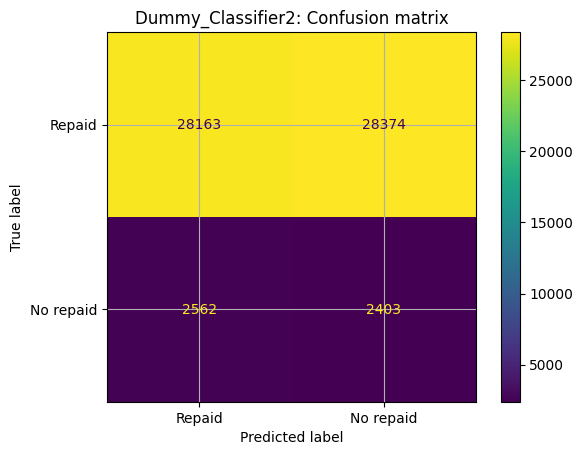

precision    recall  f1-score       support
0              0.916615  0.498134  0.645481  56537.000000
1              0.078078  0.483988  0.134464   4965.000000
accuracy       0.496992  0.496992  0.496992      0.496992
macro avg      0.497346  0.491061  0.389973  61502.000000
weighted avg   0.848921  0.496992  0.604227  61502.000000

Model time = 0.027
ROCAUC score = 0.4910609403878336
Business score = 0.7487092240550337 



Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
Setuptools is replacing distutils.


Logistic_Regression2


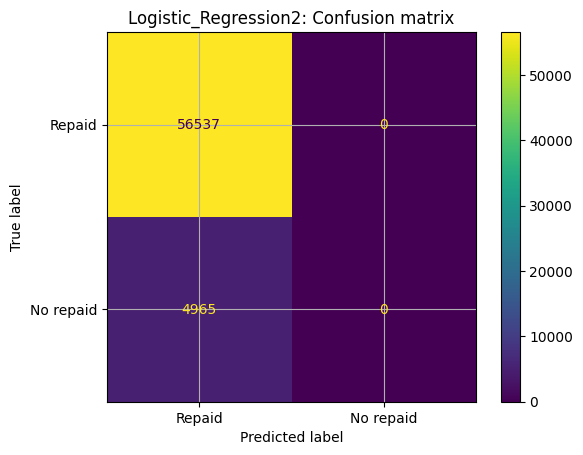

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


precision    recall  f1-score       support
0              0.919271  1.000000  0.957938  56537.000000
1              0.000000  0.000000  0.000000   4965.000000
accuracy       0.919271  0.919271  0.919271      0.919271
macro avg      0.459635  0.500000  0.478969  61502.000000
weighted avg   0.845059  0.919271  0.880604  61502.000000

Model time = 4.733
ROCAUC score = 0.521012554745628
Business score = 0.9192709180189262 



Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
Setuptools is replacing distutils.


Random_Forest2


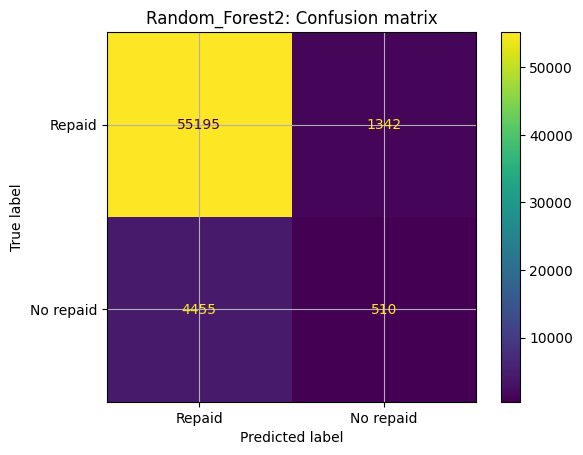

precision    recall  f1-score       support
0              0.925314  0.976263  0.950106  56537.000000
1              0.275378  0.102719  0.149626   4965.000000
accuracy       0.905743  0.905743  0.905743      0.905743
macro avg      0.600346  0.539491  0.549866  61502.000000
weighted avg   0.872846  0.905743  0.885484  61502.000000

Model time = 419.635
ROCAUC score = 0.7263666722294222
Business score = 0.9212238055322716 



Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
Setuptools is replacing distutils.


XGBoost2


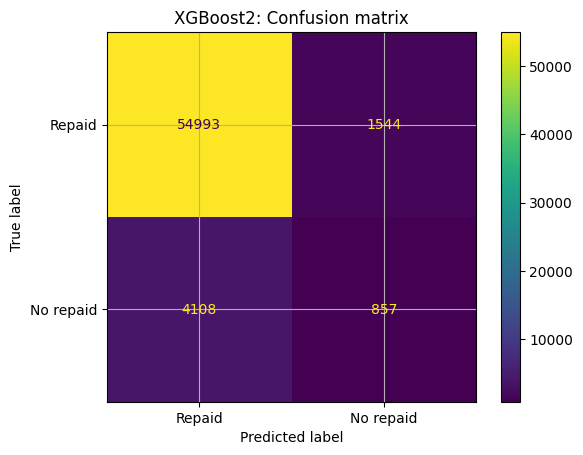

precision    recall  f1-score       support
0              0.930492  0.972690  0.951123  56537.000000
1              0.356935  0.172608  0.232691   4965.000000
accuracy       0.908101  0.908101  0.908101      0.908101
macro avg      0.643713  0.572649  0.591907  61502.000000
weighted avg   0.884189  0.908101  0.893125  61502.000000

Model time = 12.567
ROCAUC score = 0.7592522313498556
Business score = 0.9257419117658369 



Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
Setuptools is replacing distutils.


LightGBM2
[LightGBM] [Info] Number of positive: 113072, number of negative: 113072
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58726
[LightGBM] [Info] Number of data points in the train set: 226144, number of used features: 385
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


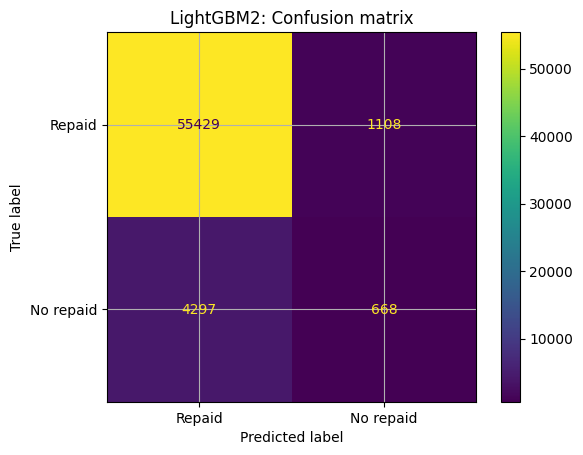

precision    recall  f1-score       support
0              0.928055  0.980402  0.953511  56537.000000
1              0.376126  0.134542  0.198190   4965.000000
accuracy       0.912117  0.912117  0.912117      0.912117
macro avg      0.652090  0.557472  0.575850  61502.000000
weighted avg   0.883498  0.912117  0.892534  61502.000000

Model time = 5.756
ROCAUC score = 0.7649193255275564
Business score = 0.9246818044828962 



Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
Setuptools is replacing distutils.


In [30]:
LIST_MODEL, LIST_ROC_AUC, LIST_DURATION, LIST_BS  = ([] for i in range(4))

for key, clf in classifiers.items():
    
    print(key)
    LIST_MODEL.append(key)
    start_time_model = timeit.default_timer()
    clf.fit(X_res, y_res)
    end_time_model =  round(timeit.default_timer() - start_time_model, 3)
    LIST_DURATION.append(end_time_model)

    # Predict probability of class 1 (repay failure)
    y_pred_proba = clf.predict_proba(X_test)[:,1]

    # Predict values 
    y_pred = clf.predict(X_test)

    # Display confusion matrix
    display_confusion_matrix(y_test, y_pred, model_name=key)

    # Compute scores
    globals()[key + "_report"] = pd.DataFrame(classification_report(y_test, y_pred, 
                                                                    output_dict=True, zero_division='warn')).transpose()
    display(globals()[key + "_report"])
    
    # Model Time
    print("Model time =", end_time_model)
    
    # ROCAUC Score
    auc_score = roc_auc_score(y_test, y_pred_proba)
    LIST_ROC_AUC.append(auc_score)
    print("ROCAUC score =", auc_score)
    
    # Display business loss func
    business_score_model = fc_business_score(y_test, y_pred)
    LIST_BS.append(business_score_model)
    print("Business score =", business_score_model, "\n")
    
    #Save logs
    if key == "Dummy_Classifier2" or key == "Logistic_Regression2":
        log_mlflow(clf, key, auc_score=auc_score, custom_score=business_score_model,
        f1_score=globals()[key + "_report"].loc['weighted avg', 'f1-score'], 
        acc_score=globals()[key + "_report"].loc['accuracy', 'precision'],
        train_class_0=Counter(y_res)[0], train_class_1=Counter(y_res)[1])
   
    else:
        clf_params = clf.get_params()
        log_mlflow(clf, key,
                   custom_score=business_score_model,
                   auc_score=auc_score,
                   f1_score=globals()[key + "_report"].loc['weighted avg', 'f1-score'], 
                   acc_score=globals()[key + "_report"].loc['accuracy', 'precision'],
                   n_estimator=clf_params['n_estimators'],
                   max_depth=clf_params['max_depth'], 
                   train_class_0=Counter(y_res)[0],
                   train_class_1=Counter(y_res)[1])

In [31]:
# Create results dataframe
res_df = pd.DataFrame({
    'Model':LIST_MODEL,
    'Business score': LIST_BS,
    'Accuracy': [Dummy_Classifier2_report.loc['accuracy', 'precision'],
                 Logistic_Regression2_report.loc['accuracy', 'precision'],
                 Random_Forest2_report.loc['accuracy', 'precision'],
                 XGBoost2_report.loc['accuracy', 'precision'],
                 LightGBM2_report.loc['accuracy', 'precision']],
    'Precision': [Dummy_Classifier2_report.loc['macro avg', 'precision'],
                 Logistic_Regression2_report.loc['macro avg', 'precision'],
                 Random_Forest2_report.loc['macro avg', 'precision'],
                 XGBoost2_report.loc['macro avg', 'precision'],
                 LightGBM2_report.loc['macro avg', 'precision']],
    'Recall': [Dummy_Classifier2_report.loc['macro avg', 'recall'],
               Logistic_Regression2_report.loc['macro avg', 'recall'],
               Random_Forest2_report.loc['macro avg', 'recall'],
               XGBoost2_report.loc['macro avg', 'recall'],
               LightGBM2_report.loc['macro avg', 'recall']],
    'F-1 score': [Dummy_Classifier2_report.loc['macro avg', 'f1-score'],
                  Logistic_Regression2_report.loc['macro avg', 'f1-score'],
                  Random_Forest2_report.loc['macro avg', 'f1-score'],
                  XGBoost2_report.loc['macro avg', 'f1-score'],
                 LightGBM2_report.loc['macro avg', 'f1-score']],
    'AUC score': LIST_ROC_AUC,
    'Duration': LIST_DURATION
})

display(res_df)

Model  Business score  Accuracy  Precision    Recall  \
0     Dummy_Classifier2        0.748709  0.496992   0.497346  0.491061   
1  Logistic_Regression2        0.919271  0.919271   0.459635  0.500000   
2        Random_Forest2        0.921224  0.905743   0.600346  0.539491   
3              XGBoost2        0.925742  0.908101   0.643713  0.572649   
4             LightGBM2        0.924682  0.912117   0.652090  0.557472   

   F-1 score  AUC score  Duration  
0   0.389973   0.491061     0.027  
1   0.478969   0.521013     4.733  
2   0.549866   0.726367   419.635  
3   0.591907   0.759252    12.567  
4   0.575850   0.764919     5.756

XGBoost and LightGBM => less time and best business score

<div style="background-color: #237ab8;" >
    <h3 style="margin: auto; padding: 15px; color:#fff; ">2.5 Hyperparameters Tuning</h3>
</div>

In [32]:
df_subsample = dataset_target.copy()
df_target_subsample = df_subsample.sample(frac=1)

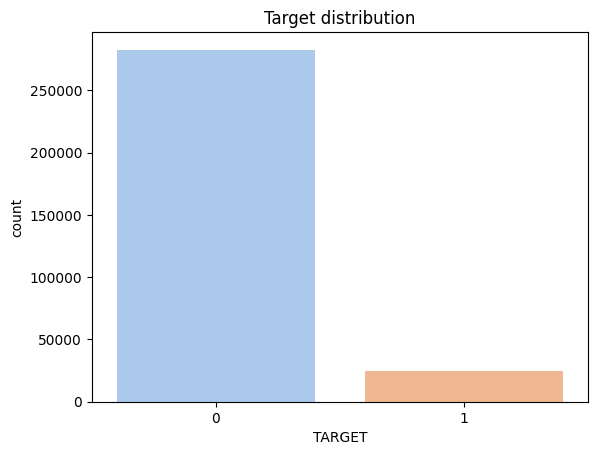

In [33]:
sns.countplot(x='TARGET', data=df_target_subsample, palette=colors)
plt.title("Target distribution")
plt.show()

In [34]:
X_sample = df_target_subsample
X_sample = X_sample.drop(columns=["TARGET", "SK_ID_CURR"])
y_target_sample = df_target_subsample.loc[:,"TARGET"]

In [35]:
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_sample, y_target_sample, test_size=0.20, stratify=y_target_sample, random_state=42)

In [36]:
# Transform the dataset
X_res_sample, y_res_sample = pipeline.fit_resample(X_train_sample, y_train_sample)

print("Training target statistics:", Counter(y_res_sample))
print("Testing target statistics:", Counter(y_test_sample))

Training target statistics: Counter({0: 113072, 1: 113072})
Testing target statistics: Counter({0: 56537, 1: 4965})


<div style="background-color: #237ab8;" >
    <h3 style="margin: auto; padding: 15px; color:#fff; ">2.6 XGBoost</h3>
</div>

In [37]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [38]:
xgboost = xgb.XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', nthread=1)

In [39]:
business_score = make_scorer(fc_business_score)
scoring = {
        'accuracy': 'accuracy',
        'f1': 'f1_macro',
        'roc_auc': 'roc_auc',
        'business': make_scorer(fc_business_score)
    }

In [40]:
folds = 5
param_comb = 5
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 42)
random_search_XGBoost = RandomizedSearchCV(xgboost, param_distributions=params, n_iter=param_comb, scoring=scoring, refit='business', n_jobs=4, cv=skf.split(X_train_sample,y_train_sample), verbose=3, random_state=42)

In [41]:
%%time
random_search_XGBoost.fit(X_train_sample,y_train_sample)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
CPU times: total: 1min 6s
Wall time: 15min 39s


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x000002888966AE60>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_...
                                           nthread=1, num_parallel_tree=None, ...),
                   n_iter=5, n_jobs=4,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [1, 5, 10],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, refit='business',
                   scoring={'accuracy': 'accuracy',
                            'business': make_scorer(fc_business_score),
                            'f1': 'f1_macro', 'roc_auc': 'roc_auc'},
                   verbose=3)

In [42]:
random_search_XGBoost.best_params_

{'subsample': 0.6,
 'min_child_weight': 10,
 'max_depth': 4,
 'gamma': 1,
 'colsample_bytree': 0.6}

In [43]:
xgb_parameters = random_search_XGBoost.best_params_

In [44]:
xgbt_best_model = xgb.XGBClassifier(**xgb_parameters, learning_rate=0.02, n_estimators=600, objective='binary:logistic', nthread=1)

Duration:  113.8


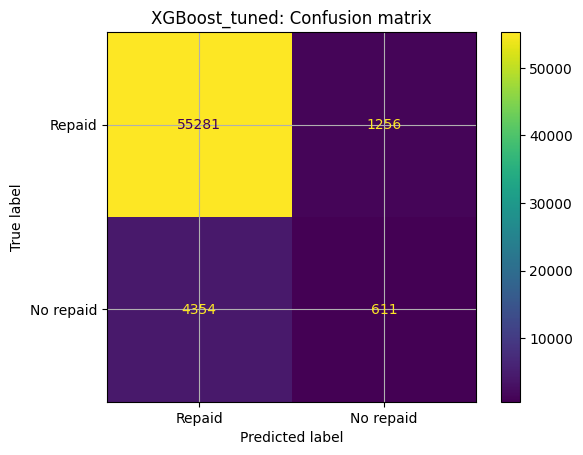

precision    recall  f1-score       support
0              0.926989  0.977784  0.951710  56537.000000
1              0.327263  0.123061  0.178864   4965.000000
accuracy       0.908783  0.908783  0.908783      0.908783
macro avg      0.627126  0.550423  0.565287  61502.000000
weighted avg   0.878574  0.908783  0.889318  61502.000000

ROCAUC score = 0.7649193255275564
Business score = 0.9231598283497336 



Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
Setuptools is replacing distutils.


In [45]:
xgbt_name = "XGBoost_tuned"
# Train model
start_time_model = timeit.default_timer()
xgbt_best_model.fit(X_res, y_res)
end_time_model =  round(timeit.default_timer() - start_time_model, 3)
print("Duration: ", end_time_model)

# Predict probability of class 1 (repay failure)
y_pred_proba = xgbt_best_model.predict_proba(X_test)[:,1]

# Predict values
y_pred = xgbt_best_model.predict(X_test)

# Display confusion matrix
display_confusion_matrix(y_test, y_pred, model_name=xgbt_name)

# Compute scores
xgbt_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
display(xgbt_report)

# ROCAUC Score
xgbt_auc = roc_auc_score(y_test, y_pred_proba)
print("ROCAUC score =", auc_score)

# Display business loss func
xgbt_business_score = fc_business_score(y_test, y_pred)
print("Business score =", xgbt_business_score, "\n")

# Save logs
xgbt_params = xgbt_best_model.get_params()
log_mlflow(xgbt_best_model, xgbt_name,
           custom_score=xgbt_business_score,
           auc_score=xgbt_auc,
           f1_score=xgbt_report.loc['weighted avg', 'f1-score'],
           acc_score=xgbt_report.loc['accuracy', 'precision'],
           n_estimator=xgbt_params['n_estimators'],
           max_depth=xgbt_params['max_depth'],
           train_class_0=Counter(y_res)[0],
           train_class_1=Counter(y_res)[1])

<div style="background-color: #237ab8;" >
    <h3 style="margin: auto; padding: 15px; color:#fff; ">2.7 LightGBM</h3>
</div>

In [46]:
params ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [47]:
lightgbm = ltb.LGBMClassifier(max_depth=-1, random_state=42, metric='None', n_jobs=4, n_estimators=5000)

In [48]:
folds = 5
param_comb = 5
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 42)
random_search_lightgbm = RandomizedSearchCV(lightgbm, param_distributions=params, n_iter=param_comb, scoring=scoring, refit='business', n_jobs=4, cv=skf.split(X_train_sample,y_train_sample), verbose=3, random_state=42)

In [49]:
%%time
random_search_lightgbm.fit(X_train_sample,y_train_sample)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.249115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28705
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 368
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432469
[LightGBM] [Info] Start training from score -2.432469
CPU times: total: 3min 35s
Wall time: 22min 11s


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x000002888966B9A0>,
                   estimator=LGBMClassifier(metric='None', n_estimators=5000,
                                            n_jobs=4, random_state=42),
                   n_iter=5, n_jobs=4,
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000287FB13D690>,
                                        'min_child_samples': <scipy.stats._distn_infrastruc...
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000028889724390>,
                                        'reg_alpha': [0, 0.1, 1, 2, 5, 7, 10,
                                                      50, 100],
                                        'reg_lambda': [0, 0.1, 1, 5, 10, 20, 50,
                                                       100],
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000287FB0D3B90>},
                   random_state=42, refit='business',
                   scoring={'accuracy': 'accuracy',
                            'business': make_scorer(fc_business_score),
                            'f1': 'f1_macro', 'roc_auc': 'roc_auc'},
                   verbose=3)

In [50]:
random_search_lightgbm.best_params_

{'colsample_bytree': 0.7554487413172255,
 'min_child_samples': 230,
 'min_child_weight': 1,
 'num_leaves': 12,
 'reg_alpha': 5,
 'reg_lambda': 0,
 'subsample': 0.25204127438822366}

In [51]:
lightgbm_parameters = random_search_lightgbm.best_params_

In [52]:
lightgbm_best_model = ltb.LGBMClassifier(**lightgbm_parameters, max_depth=-1, random_state=314, metric='None', n_jobs=4, n_estimators=5000)

[LightGBM] [Info] Number of positive: 113072, number of negative: 113072
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.263405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58688
[LightGBM] [Info] Number of data points in the train set: 226144, number of used features: 369
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Duration:  112.913


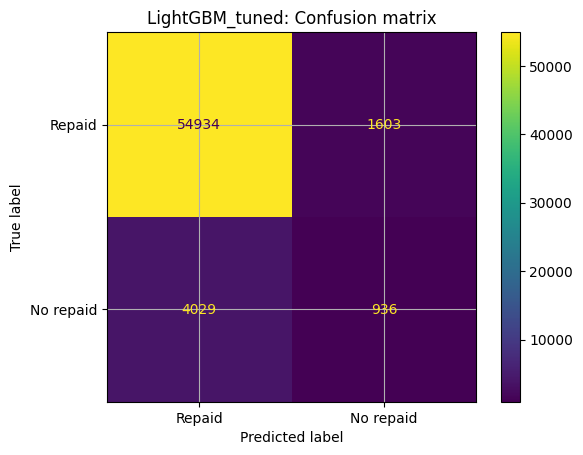

precision    recall  f1-score       support
0              0.931669  0.971647  0.951238  56537.000000
1              0.368649  0.188520  0.249467   4965.000000
accuracy       0.908426  0.908426  0.908426      0.908426
macro avg      0.650159  0.580083  0.600353  61502.000000
weighted avg   0.886217  0.908426  0.894585  61502.000000

ROCAUC score = 0.7649193255275564
Business score = 0.9267260053685439 



Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
Setuptools is replacing distutils.


In [53]:
lightgbm_name = "LightGBM_tuned"
# Train model
start_time_model = timeit.default_timer()
lightgbm_best_model.fit(X_res, y_res)
end_time_model =  round(timeit.default_timer() - start_time_model, 3)
print("Duration: ", end_time_model)

# Predict probability of class 1 (repay failure)
y_pred_proba = lightgbm_best_model.predict_proba(X_test)[:,1]

# Predict values
y_pred = lightgbm_best_model.predict(X_test)

# Display confusion matrix
display_confusion_matrix(y_test, y_pred, model_name=lightgbm_name)

# Compute scores
lightgbm_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
display(lightgbm_report)

# ROCAUC Score
lightgbm_auc = roc_auc_score(y_test, y_pred_proba)
print("ROCAUC score =", auc_score)

# Display business loss func
lightgbm_business_score = fc_business_score(y_test, y_pred)
print("Business score =", lightgbm_business_score, "\n")

# Save logs
lightgbm_params = lightgbm_best_model.get_params()
log_mlflow(lightgbm_best_model, lightgbm_name,
           custom_score=lightgbm_business_score,
           auc_score=lightgbm_auc,
           f1_score=lightgbm_report.loc['weighted avg', 'f1-score'],
           acc_score=lightgbm_report.loc['accuracy', 'precision'],
           n_estimator=lightgbm_params['n_estimators'],
           max_depth=lightgbm_params['max_depth'],
           train_class_0=Counter(y_res)[0],
           train_class_1=Counter(y_res)[1])

Even though  it takes longer to fit LightGBM, the business score is slightly better for this model

<div style="background-color: #237ab8;" >
    <h3 style="margin: auto; padding: 15px; color:#fff; ">2.8 Model Pipeline</h3>
</div>

In [117]:
# Define oversampling and undersampling
over = SMOTE(sampling_strategy=0.5) # oversample to 1:2 ratio 
under = RandomUnderSampler(sampling_strategy=1) # undersample to 1:1 ratio

X = dataset_target
X = X.drop(columns=["TARGET", "SK_ID_CURR"])
y_target = dataset_target.loc[:,"TARGET"]

# Create a pipeline with preprocessing and LightGBM model
pipeline = Pipeline([
    ('over', over), 
    ('under', under),
    ('classifier', ltb.LGBMClassifier(colsample_bytree=0.7554487413172255, min_child_samples=230,
                                  min_child_weight=1, num_leaves=12, reg_alpha=5, reg_lambda=0, 
                                  subsample=0.25204127438822366, max_depth=-1, random_state=314, 
                                  metric='None', n_jobs=4, n_estimators=5000))
])

In [118]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_target, test_size=0.20, stratify=y_target, random_state=42)

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

y_pred_proba = pipeline.predict_proba(X_test)[:,1]

# Predict values
y_pred = pipeline.predict(X_test)

[LightGBM] [Info] Number of positive: 113072, number of negative: 113072
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.157436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58693
[LightGBM] [Info] Number of data points in the train set: 226144, number of used features: 369
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


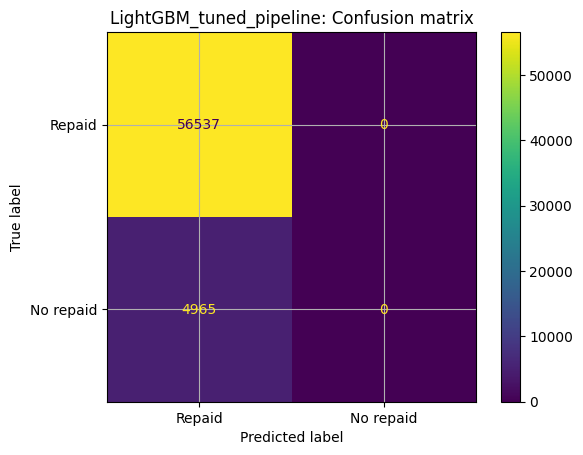

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


precision    recall  f1-score       support
0              0.919271  1.000000  0.957938  56537.000000
1              0.000000  0.000000  0.000000   4965.000000
accuracy       0.919271  0.919271  0.919271      0.919271
macro avg      0.459635  0.500000  0.478969  61502.000000
weighted avg   0.845059  0.919271  0.880604  61502.000000

ROCAUC score = 0.7649193255275564
Business score = 0.9192709180189262 



Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
Setuptools is replacing distutils.


In [125]:
lightgbm_name = "LightGBM_tuned_pipeline"
# Display confusion matrix
display_confusion_matrix(y_test, y_pred, model_name=lightgbm_name)

# Compute scores
lightgbm_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
display(lightgbm_report)

# ROCAUC Score
lightgbm_auc = roc_auc_score(y_test, y_pred_proba)
print("ROCAUC score =", auc_score)

# Display business loss func
lightgbm_business_score = fc_business_score(y_test, y_pred)
print("Business score =", lightgbm_business_score, "\n")

# Save logs
lightgbm_params = pipeline.get_params()
log_mlflow(pipeline['classifier'], lightgbm_name,
           custom_score=lightgbm_business_score,
           auc_score=lightgbm_auc,
           f1_score=lightgbm_report.loc['weighted avg', 'f1-score'],
           acc_score=lightgbm_report.loc['accuracy', 'precision'],
           n_estimator=lightgbm_params['classifier__n_estimators'],
           max_depth=lightgbm_params['classifier__max_depth'],
           train_class_0=Counter(y_res)[0],
           train_class_1=Counter(y_res)[1])

<div style="background-color: #16537e;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">3. Threshold Selection</h2>
</div>

divide by zero encountered in scalar divide


Best results
- Best Threshold:	 0.426
- Best Score:		 0.928




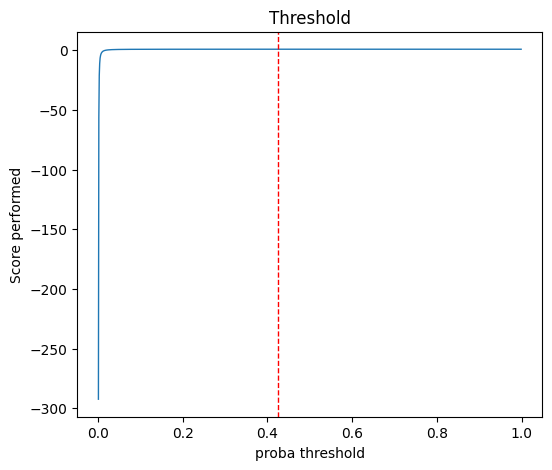

In [126]:
thresholds = np.arange(0, 1, 0.001)
scores = []

for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype("int")
    score = fc_business_score(y_test, y_pred)
    scores.append(score)
        
scores = np.asarray(scores)
ix = np.argmax(scores)

best_threshold, best_score = (thresholds[ix], round(scores[ix], 3))

print("Best results")
print("- Best Threshold:\t", best_threshold)
print("- Best Score:\t\t", best_score)
print("\n")

plt.subplots(1, figsize=(6, 5))
plt.plot(thresholds, scores, lw=1)
plt.axvline(best_threshold, ls="--", lw=1, c="r")
plt.title("Threshold")
plt.xlabel("proba threshold")
plt.ylabel("Score performed")
plt.show()

In [127]:
y_pred = (y_pred_proba >= best_threshold).astype("int")

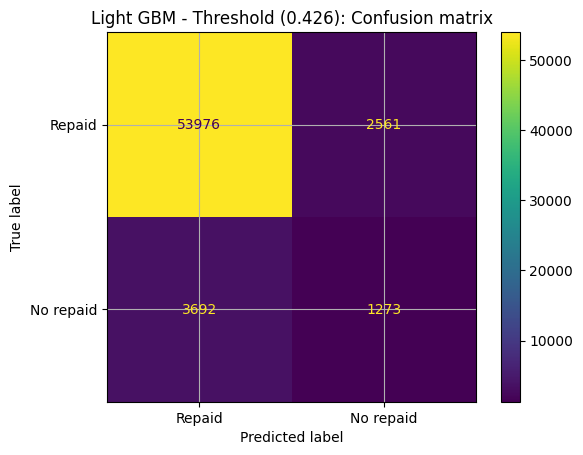

precision    recall  f1-score       support
0              0.935978  0.954702  0.945248  56537.000000
1              0.332029  0.256395  0.289351   4965.000000
accuracy       0.898329  0.898329  0.898329      0.898329
macro avg      0.634004  0.605548  0.617299  61502.000000
weighted avg   0.887222  0.898329  0.892298  61502.000000

ROCAUC score = 0.7649193255275564
Business score = 0.9279039265513567 



In [128]:
# Display confusion matrix
display_confusion_matrix(y_test, y_pred, model_name="Light GBM - Threshold (0.426)")

# Compute scores
lightgbm_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
display(lightgbm_report)

# ROCAUC Score
lightgbm_auc = roc_auc_score(y_test, y_pred)
print("ROCAUC score =", auc_score)

# Display business loss func
lightgbm_business_score = fc_business_score(y_test, y_pred)
print("Business score =", lightgbm_business_score, "\n")

<div style="background-color: #16537e;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">4. Feature importance</h2>
</div>

In [129]:
feature_names = list(dataset_target.columns)
feature_names.remove('TARGET')
feature_names.remove('SK_ID_CURR')

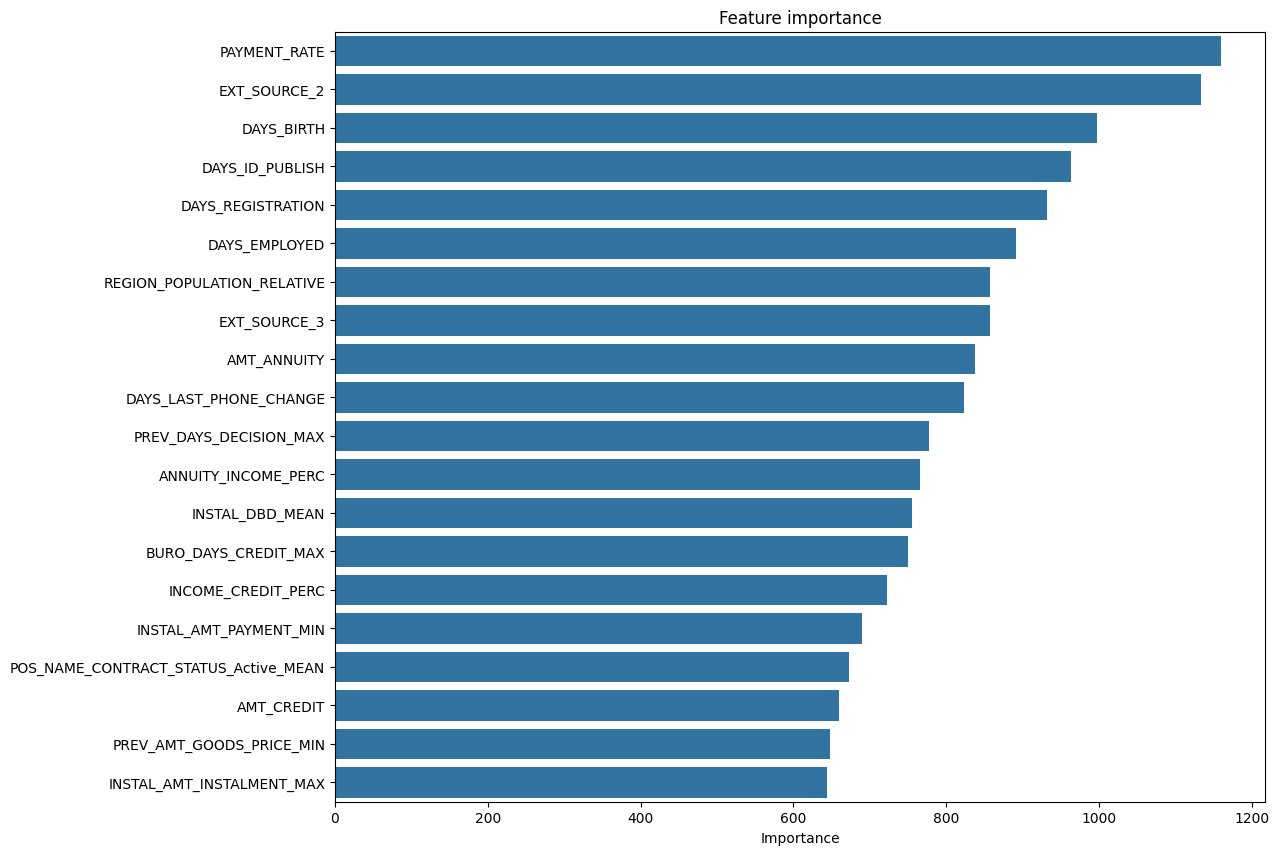

In [132]:
values = sorted(zip(pipeline['classifier'].feature_importances_, feature_names), reverse=True)[:20]
plt.figure(figsize=(12, 10))
plt.title("Feature importance")
sns.barplot(x=np.array(list(zip(*values))[0]), y=np.array(list(zip(*values))[1]))
plt.xlabel('Importance')
plt.show()

<div style="background-color: #237ab8;" >
    <h3 style="margin: auto; padding: 15px; color:#fff; ">4.1 LIME</h3>
</div>

In [133]:
explainer = lime_tabular.LimeTabularExplainer(np.array(X_res), mode="classification",
                                              class_names=['Repaid', 'No Repaid'],
                                              feature_names=feature_names,
                                             )

explainer

In [134]:
idx = random.randint(1, len(X_test))
print("Prediction : ", y_pred[idx])
print("Actual :     ", y_test[X_test.index[idx]])

explanation = explainer.explain_instance(X_test.iloc[idx], pipeline['classifier'].predict_proba)

explanation.show_in_notebook()
explanation.as_list()

Prediction :  0
Actual :      0


[('ORGANIZATION_TYPE_Insurance <= 0.00', 0.058870141196051176),
 ('NAME_TYPE_SUITE_Other_A <= 0.00', 0.03841613467447578),
 ('OCCUPATION_TYPE_ITstaff <= 0.00', -0.02680981259026366),
 ('ORGANIZATION_TYPE_LegalServices <= 0.00', 0.025146390950282718),
 ('ORGANIZATION_TYPE_Industrytype13 <= 0.00', -0.01969675982356752),
 ('ORGANIZATION_TYPE_Advertising <= 0.00', -0.01958825725876843),
 ('ORGANIZATION_TYPE_Industrytype8 <= 0.00', -0.01599926107151537),
 ('NAME_EDUCATION_TYPE_Academicdegree <= 0.00', -0.01597402347801775),
 ('ORGANIZATION_TYPE_Industrytype12 <= 0.00', -0.013979090479546588),
 ('FLAG_DOCUMENT_14 <= 0.00', -0.010231453771183502)]

In [135]:
preds = y_pred

false_preds = np.argwhere((preds != y_test.to_list())).flatten()

idx  = random.choice(false_preds)

print("Prediction : ", y_pred[idx])
print("Actual :     ", y_test[X_test.index[idx]])

explanation = explainer.explain_instance(X_test.iloc[idx], pipeline['classifier'].predict_proba)

explanation.show_in_notebook()

Prediction :  0
Actual :      1


<div style="background-color: #237ab8;" >
    <h3 style="margin: auto; padding: 15px; color:#fff; ">4.2 SHAP</h3>
</div>

In [136]:
shap_explainer = shap.TreeExplainer(pipeline['classifier'])

In [137]:
shap_vals = shap_explainer.shap_values(X_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [138]:
y_pred[0]

0

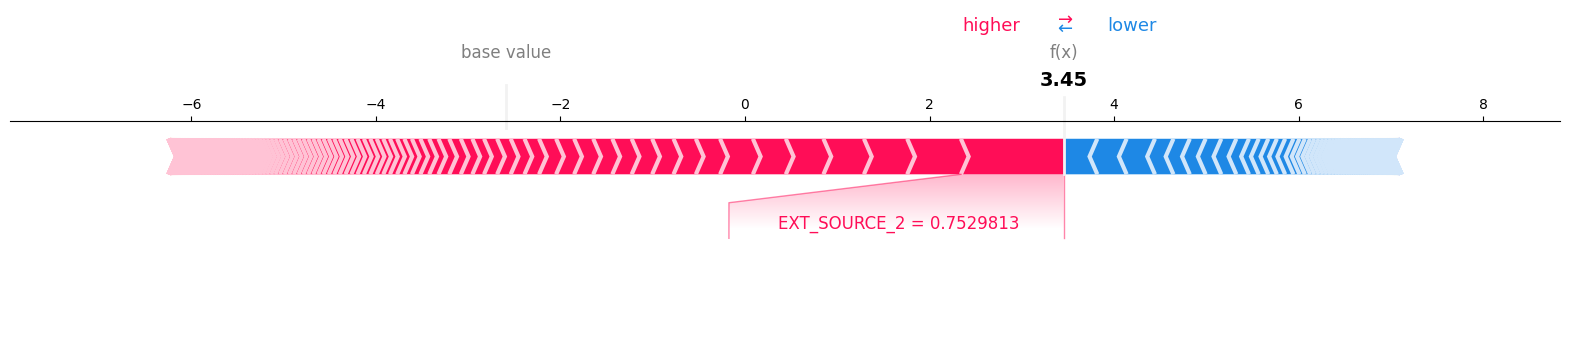

In [139]:
shap.force_plot(shap_explainer.expected_value[0], 
                shap_vals[0][0, :], 
                X_test.iloc[0, :],
               matplotlib=True)

In [146]:
# Example NumPy array
arr = y_pred

# Find the index where the first occurrence of 1 occurs
index = np.where(arr == 1)[0]

# Check if any occurrences were found
if index.size > 0:
    first_occurrence_index = index[0]
    print("Index of the first occurrence of 1:", first_occurrence_index)
else:
    print("Value 1 not found in the array")

Index of the first occurrence of 1: 41


In [147]:
y_pred[41]

1

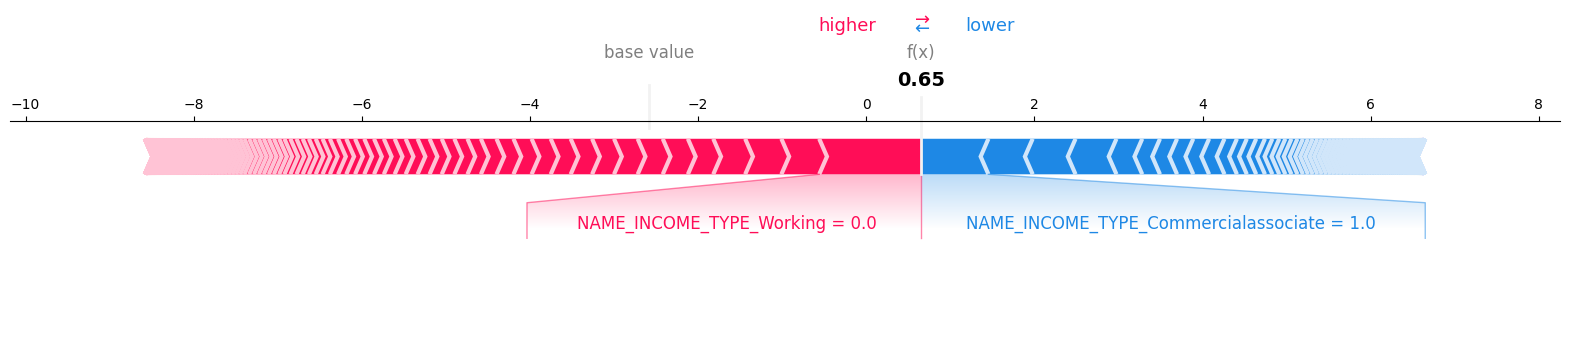

In [148]:
shap.force_plot(shap_explainer.expected_value[0], 
                shap_vals[0][21, :], 
                X_test.iloc[21, :],
               matplotlib=True)

In [149]:
dataset_predict

SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0          100001     NaN            1             0                0   
1          100005     NaN            0             0                0   
2          100013     NaN            0             1                0   
3          100028     NaN            1             0                0   
4          100038     NaN            0             1                1   
...           ...     ...          ...           ...              ...   
48739      456221     NaN            1             0                0   
48740      456222     NaN            1             0                1   
48741      456223     NaN            1             1                0   
48742      456224     NaN            0             0                1   
48743      456250     NaN            1             1                1   

       CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                 0          135000.0    568800.0      20560.5   
1                 0           99000.0    222768.0      17370.0   
2                 0          202500.0    663264.0      69777.0   
3                 2          315000.0   1575000.0      49018.5   
4                 1          180000.0    625500.0      32067.0   
...             ...               ...         ...          ...   
48739             0          121500.0    412560.0      17473.5   
48740             2          157500.0    622413.0      31909.5   
48741             1          202500.0    315000.0      33205.5   
48742             0          225000.0    450000.0      25128.0   
48743             0          135000.0    312768.0      24709.5   

       REGION_POPULATION_RELATIVE  ...  INSTAL_PAYMENT_DIFF_MAX  \
0                        0.018850  ...                     0.00   
1                        0.035792  ...                     0.00   
2                        0.019101  ...                 23147.82   
3                        0.026392  ...                  8505.00   
4                        0.010032  ...                     0.00   
...                           ...  ...                      ...   
48739                    0.002042  ...                     0.00   
48740                    0.035792  ...                  9680.49   
48741                    0.026392  ...                     0.00   
48742                    0.018850  ...                     0.00   
48743                    0.006629  ...                  9000.00   

       INSTAL_PAYMENT_DIFF_MEAN  INSTAL_PAYMENT_DIFF_SUM  \
0                        0.0000                    0.000   
1                        0.0000                    0.000   
2                     1157.6627               179437.720   
3                      622.5507                70348.230   
4                        0.0000                    0.000   
...                         ...                      ...   
48739                    0.0000                    0.000   
48740                  314.7146                22974.164   
48741                    0.0000                    0.000   
48742                    0.0000                    0.000   
48743                  193.0797                 9653.985   

       INSTAL_PAYMENT_DIFF_VAR  INSTAL_AMT_INSTALMENT_MAX  \
0                 0.000000e+00                  17397.900   
1                 0.000000e+00                  17656.244   
2                 2.346772e+07                 357347.750   
3                 2.972476e+06                  38988.540   
4                 0.000000e+00                  11100.600   
...                        ...                        ...   
48739             0.000000e+00                 244664.500   
48740             2.023069e+06                  14571.765   
48741             0.000000e+00                  81184.010   
48742             0.000000e+00                  23451.705   
48743             1.623749e+06                  26474.625   

       INSTAL_AMT_INSTALMENT_MEAN  INSTAL_AMT_INSTALMENT_SUM  \
0             

In [152]:
clients_id = dataset_predict["SK_ID_CURR"].tolist()
clients_repay = []

for client in clients_id:
        # Filtering by client's id
        df_prediction_by_id = dataset_predict[dataset_predict["SK_ID_CURR"] == client]
        df_prediction_by_id = df_prediction_by_id.drop(columns=["SK_ID_CURR", "TARGET", "REPAY"])

        # Predicting
        result_proba = pipeline['classifier'].predict_proba(df_prediction_by_id)
        y_prob = result_proba[:, 1]
        
        result = (y_prob >= best_threshold).astype(int)

        if (int(result[0]) == 0):
            clients_repay.append(True)
        else:
            clients_repay.append(False)

In [153]:
dataset_predict["REPAY"] = clients_repay

In [154]:
filename = 'models/lightgbm_model.pckl'
pickle.dump(pipeline['classifier'], open(filename, 'wb'))

In [155]:
filename = 'models/shap_explainer.pckl'
pickle.dump(shap_explainer, open(filename, 'wb'))

In [157]:
dataset_predict.to_csv("dataset_predict.csv", index=False)

<div style="background-color: #16537e;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">5. Clustering exploratory data analysis</h2>
</div>

In [39]:
dataset_target["LABEL"] = "target"
dataset_predict["LABEL"] = "predict"
dataset_kmeans = pd.concat([dataset_target.drop(columns=["SK_ID_CURR", "TARGET"]), dataset_predict.drop(columns=["SK_ID_CURR", "TARGET", "REPAY"])], axis=0)
dataset_kmeans

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
0                0             0                0             0   
1                1             0                1             0   
2                0             1                0             0   
3                1             0                0             0   
4                0             0                0             0   
...            ...           ...              ...           ...   
48739            1             0                0             0   
48740            1             0                1             2   
48741            1             1                0             1   
48742            0             0                1             0   
48743            1             1                1             0   

       AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  REGION_POPULATION_RELATIVE  \
0              202500.0    406597.5      24700.5                    0.018801   
1              270000.0   1293502.5      35698.5                    0.003541   
2               67500.0    135000.0       6750.0                    0.010032   
3              135000.0    312682.5      29686.5                    0.008019   
4              121500.0    513000.0      21865.5                    0.028663   
...                 ...         ...          ...                         ...   
48739          121500.0    412560.0      17473.5                    0.002042   
48740          157500.0    622413.0      31909.5                    0.035792   
48741          202500.0    315000.0      33205.5                    0.026392   
48742          225000.0    450000.0      25128.0                    0.018850   
48743          135000.0    312768.0      24709.5                    0.006629   

       DAYS_BIRTH  DAYS_EMPLOYED  ...  INSTAL_PAYMENT_DIFF_MAX  \
0           -9461         -637.0  ...                    0.000   
1          -16765        -1188.0  ...                    0.000   
2          -19046         -225.0  ...                    0.000   
3          -19005        -3039.0  ...                    0.000   
4          -19932        -3038.0  ...                22655.654   
...           ...            ...  ...                      ...   
48739      -19970        -5169.0  ...                    0.000   
48740      -11186        -1149.0  ...                 9680.490   
48741      -15922        -3037.0  ...                    0.000   
48742      -13968        -2731.0  ...                    0.000   
48743      -13962         -633.0  ...                 9000.000   

       INSTAL_PAYMENT_DIFF_MEAN  INSTAL_PAYMENT_DIFF_SUM  \
0                        0.0000                    0.000   
1                        0.0000                    0.000   
2                        0.0000                    0.000   
3                        0.0000                    0.000   
4                      452.3843                29857.365   
...                         ...                      ...   
48739                    0.0000                    0.000   
48740                  314.7146                22974.164   
48741                    0.0000                    0.000   
48742                    0.0000                    0.000   
48743                  193.0797                 9653.985   

       INSTAL_PAYMENT_DIFF_VAR  INSTAL_AMT_INSTALMENT_MAX  \
0                 0.000000e+00                  53093.746   
1                 0.000000e+00                 560835.400   
2                 0.000000e+00                  10573.965   
3                 0.000000e+00                 691786.900   
4                 8.084830e+06                  22678.785   
...                        ...                        ...   
48739             0.000000e+00                 244664.500   
48740             2.023069e+06                  14571.765   
48741             0.000000e+00                  81184.010   
48742             0.000000e+00                  23451.705   
48743             1.623749e+06                  26474.62

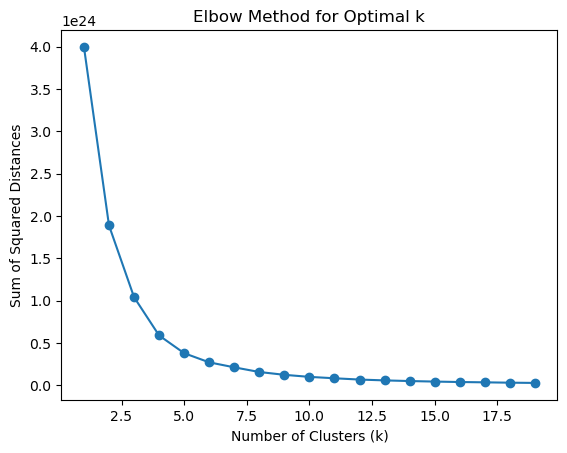

In [24]:
# Data
X = dataset_kmeans.drop(columns=["LABEL"])

k_values = range(1, 20)
# Calculate sum of squared distances for different values of k

sse = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    labels = kmeans.labels_
    sse.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.plot(k_values, sse, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.show()

In [40]:
features = list(dataset_kmeans.columns)
features = features[:-1]

In [41]:
x = dataset_kmeans.loc[:, features].values
x = StandardScaler().fit_transform(x) # normalizing the features

In [42]:
feat_cols = ['feature'+str(i) for i in range(x.shape[1])]
normalised_dataset_kmeans = pd.DataFrame(x,columns=feat_cols)
normalised_dataset_kmeans.tail()

feature0  feature1  feature2  feature3  feature4  feature5  feature6  \
356246  0.717739 -0.717259 -0.665214 -0.575133 -0.217513 -0.439535 -0.675542   
356247  0.717739 -0.717259  1.503275  2.201198 -0.056445  0.086907  0.304360   
356248  0.717739  1.394197 -0.665214  0.813032  0.144890 -0.684276  0.392331   
356249 -1.393264 -0.717259  1.503275 -0.575133  0.245558 -0.345612 -0.155962   
356250  0.717739  1.394197  1.503275 -0.575133 -0.157113 -0.689876 -0.184369   

        feature7  feature8  feature9  ...  feature402  feature403  feature404  \
356246 -1.356445 -0.901333 -1.312629  ...   -0.012983   -0.454953    0.076349   
356247  1.068995  1.113904  0.590744  ...   -0.014463    0.195829    0.137834   
356248  0.393465  0.027365 -0.303178  ...   -0.012983   -0.454953    0.076349   
356249 -0.148540  0.475654 -0.158294  ...   -0.012983   -0.454953    0.076349   
356250 -1.026801  0.477030  0.835058  ...   -0.013703    0.150082    0.114071   

        feature405  feature406  feature407  feature408  feature409  \
356246    0.043194   -0.103452    0.441068    3.161139   -0.470089   
356247    0.175549   -0.102848   -0.511792   -0.459616   -0.106442   
356248    0.043194   -0.103452   -0.235937    0.198309   -0.570795   
356249    0.043194   -0.103452   -0.475018   -0.058777   -0.209033   
356250    0.098811   -0.102967   -0.462499   -0.234737   -0.024337   

        feature410  feature411  
356246    0.631541    0.724322  
356247   -0.373011   -0.546946  
356248    0.519818    0.673887  
356249    0.016753    0.275216  
356250   -0.373125    0.428971  

[5 rows x 412 columns]

In [45]:
pca = PCA() #If we do not specify how many components, all are included
X_r = pca.fit(normalised_dataset_kmeans).transform(normalised_dataset_kmeans)

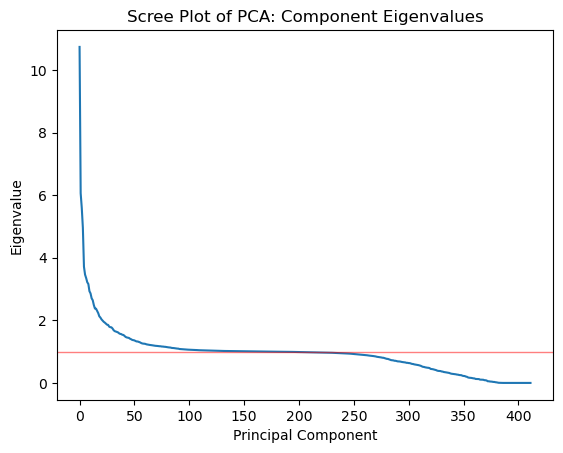

In [46]:
scree_plot()

In [47]:
next(x[0] for x in enumerate(pca.explained_variance_) if x[1] < 1)

173

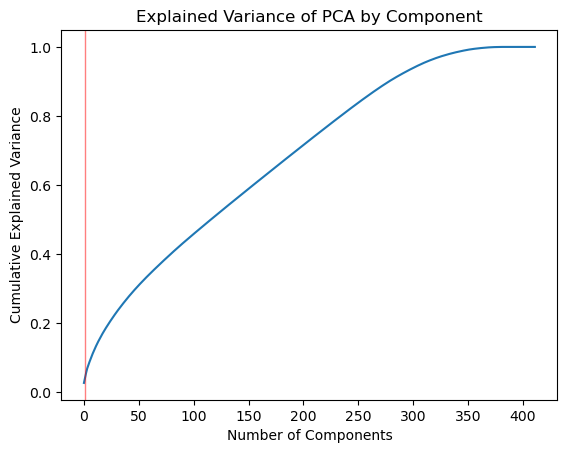

In [48]:
var_explained()

In [49]:
pca = PCA(n_components = 0.7)
pca.fit(normalised_dataset_kmeans)
pca_dataset_kmeans = pca.transform(normalised_dataset_kmeans)
pca_dataset_kmeans

array([[-3.55790123,  3.3305858 ,  1.13512249, ...,  3.0088814 ,
         0.18080693, -2.57907965],
       [ 1.36803212, -0.51289064,  4.68595723, ...,  0.97401746,
        -0.01439013,  0.18738543],
       [-5.227676  , -0.40239703, -0.7868959 , ...,  0.03477059,
        -0.06733789, -0.61292281],
       ...,
       [-3.04558319,  2.4174895 ,  0.85476046, ..., -0.26048781,
         0.02391543, -0.68580979],
       [ 0.90385546, -0.46996606, -0.60748101, ..., -0.49185066,
         0.50296371,  0.35936346],
       [ 1.77352531,  1.99499185, -2.88159695, ...,  0.03253519,
        -0.49806657,  0.53456075]])

In [50]:
pca_dataset_kmeans_df = pd.DataFrame(data = pca_dataset_kmeans)
pca_dataset_kmeans_dfpca_dataset_kmeans_df = pd.DataFrame(data = pca_dataset_kmeans)
pca_dataset_kmeans_df

0         1         2         3         4         5         6    \
0      -3.557901  3.330586  1.135122 -2.917390 -0.059581  1.130746  3.968851   
1       1.368032 -0.512891  4.685957  2.353799 -0.052311  0.854218 -1.071084   
2      -5.227676 -0.402397 -0.786896 -1.620790  1.509136 -0.120138  2.585704   
3       3.001346  1.293243 -0.360549 -1.200522  1.178416  1.052886  1.176228   
4       1.331310 -2.820771 -0.328420  0.314881 -0.870570 -1.526358  1.300240   
...          ...       ...       ...       ...       ...       ...       ...   
356246  1.253779  5.009683  2.948686 -2.412675 -2.028899 -6.836408  1.733332   
356247 -0.486297 -1.959386 -1.379085  1.815966 -1.076441 -0.994517 -0.143152   
356248 -3.045583  2.417489  0.854760  0.532189  0.730285  2.559645 -0.131269   
356249  0.903855 -0.469966 -0.607481  1.568014  3.230424 -1.585657 -0.267439   
356250  1.773525  1.994992 -2.881597 -0.935940 -0.284281  0.652859  0.032748   

             7         8         9    ...       185       186       187  \
0      -3.459841  1.415448 -2.348663  ...  1.261383 -0.047180 -0.835999   
1      -0.464329  0.967455 -2.113242  ...  0.485958 -0.101913  0.137318   
2       0.689068 -1.873347  0.934803  ...  0.156942  0.004686 -0.801650   
3      -1.041407 -1.579617  0.164803  ...  0.231085  0.076666 -0.060933   
4       0.225961 -1.268121  0.404642  ... -5.363517  1.885258  0.491070   
...          ...       ...       ...  ...       ...       ...       ...   
356246  5.923952  0.502403  0.155349  ...  0.244180  1.180253 -4.870421   
356247 -0.649737  0.354517 -1.124106  ... -0.087665 -0.497612 -0.449129   
356248  0.407453 -0.643979 -2.463136  ...  0.357512  0.230318 -0.398081   
356249 -0.242416  0.785818 -0.185938  ... -0.592882 -0.407058 -0.219115   
356250 -1.800407  2.019405  1.504724  ... -0.303257 -0.011577 -0.390803   

             188       189       190       191       192       193       194  
0       2.487437 -1.935893  0.041850  2.863545  3.008881  0.180807 -2.579080  
1      -0.095707 -0.084580 -0.350418 -0.373502  0.974017 -0.014390  0.187385  
2      -0.102717 -0.101626  0.636008  0.257983  0.034771 -0.067338 -0.612923  
3      -0.105902  0.053059 -0.266195 -0.117686  0.092740 -0.250047  0.120481  
4       2.678991 -4.861616  2.652088 -6.587661 -1.003847 -1.294531 -4.601686  
...          ...       ...       ...       ...       ...       ...       ...  
356246 -8.929017  4.848056 -4.165713  2.649107  2.157310  0.315678  4.335234  
356247 -0.076720  0.261444 -0.098158 -0.062264  0.195793  0.160148 -0.427769  
356248  0.257222 -0.122624  0.304995 -0.313454 -0.260488  0.023915 -0.685810  
356249 -0.100675 -0.072072  0.414617 -0.056331 -0.491851  0.502964  0.359363  
356250  0.044925  0.198485 -0.027116  0.138644  0.032535 -0.498067  0.534561  

[356251 rows x 195 columns]

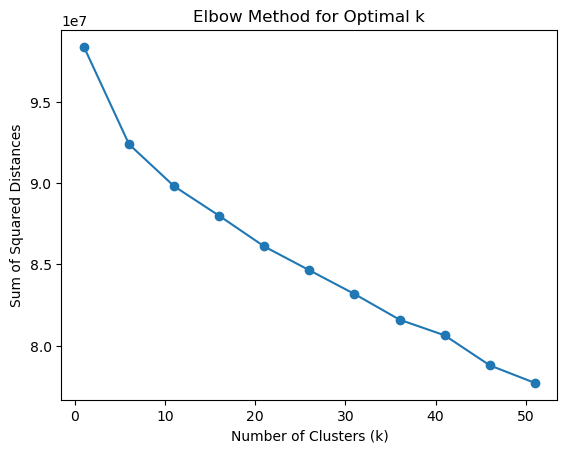

In [52]:
# Data
X = pca_dataset_kmeans_df

k_values = range(1, 52, 5)
# Calculate sum of squared distances for different values of k

sse = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    labels = kmeans.labels_
    sse.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.plot(k_values, sse, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.show()

In [25]:
X = dataset_kmeans.drop(columns=["LABEL"])
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(X)

KMeans(n_clusters=5, n_init=10, random_state=0)

In [29]:
dataset_kmeans["CLUSTER"] = kmeans.labels_

In [31]:
dataset_kmeans = dataset_kmeans.loc[dataset_kmeans["LABEL"] == "predict"]
dataset_kmeans

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
0                1             0                0             0   
1                0             0                0             0   
2                0             1                0             0   
3                1             0                0             2   
4                0             1                1             1   
...            ...           ...              ...           ...   
48739            1             0                0             0   
48740            1             0                1             2   
48741            1             1                0             1   
48742            0             0                1             0   
48743            1             1                1             0   

       AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  REGION_POPULATION_RELATIVE  \
0              135000.0    568800.0      20560.5                    0.018850   
1               99000.0    222768.0      17370.0                    0.035792   
2              202500.0    663264.0      69777.0                    0.019101   
3              315000.0   1575000.0      49018.5                    0.026392   
4              180000.0    625500.0      32067.0                    0.010032   
...                 ...         ...          ...                         ...   
48739          121500.0    412560.0      17473.5                    0.002042   
48740          157500.0    622413.0      31909.5                    0.035792   
48741          202500.0    315000.0      33205.5                    0.026392   
48742          225000.0    450000.0      25128.0                    0.018850   
48743          135000.0    312768.0      24709.5                    0.006629   

       DAYS_BIRTH  DAYS_EMPLOYED  ...  INSTAL_PAYMENT_DIFF_MEAN  \
0          -19241        -2329.0  ...                    0.0000   
1          -18064        -4469.0  ...                    0.0000   
2          -20038        -4458.0  ...                 1157.6627   
3          -13976        -1866.0  ...                  622.5507   
4          -13040        -2191.0  ...                    0.0000   
...           ...            ...  ...                       ...   
48739      -19970        -5169.0  ...                    0.0000   
48740      -11186        -1149.0  ...                  314.7146   
48741      -15922        -3037.0  ...                    0.0000   
48742      -13968        -2731.0  ...                    0.0000   
48743      -13962         -633.0  ...                  193.0797   

       INSTAL_PAYMENT_DIFF_SUM  INSTAL_PAYMENT_DIFF_VAR  \
0                        0.000             0.000000e+00   
1                        0.000             0.000000e+00   
2                   179437.720             2.346772e+07   
3                    70348.230             2.972476e+06   
4                        0.000             0.000000e+00   
...                        ...                      ...   
48739                    0.000             0.000000e+00   
48740                22974.164             2.023069e+06   
48741                    0.000             0.000000e+00   
48742                    0.000             0.000000e+00   
48743                 9653.985             1.623749e+06   

       INSTAL_AMT_INSTALMENT_MAX  INSTAL_AMT_INSTALMENT_MEAN  \
0                      17397.900                   5885.1323   
1                      17656.244                   6240.2050   
2                     357347.750                  10897.8980   
3                      38988.540                   4979.2820   
4                      11100.600                  11100.3380   
...                          ...                         ...   
48739                 244664.500                  91036.4500   
48740                  14571.765                   8086.1620   
48741                  81184.010                  23158.9920   
48742                  23451.705                  17269.2340   
48743                  

In [33]:
dataset_predict = dataset_predict.drop(columns=["LABEL"])
dataset_predict["CLUSTER"] = dataset_kmeans["CLUSTER"]

In [34]:
dataset_predict

SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0          100001     NaN            1             0                0   
1          100005     NaN            0             0                0   
2          100013     NaN            0             1                0   
3          100028     NaN            1             0                0   
4          100038     NaN            0             1                1   
...           ...     ...          ...           ...              ...   
48739      456221     NaN            1             0                0   
48740      456222     NaN            1             0                1   
48741      456223     NaN            1             1                0   
48742      456224     NaN            0             0                1   
48743      456250     NaN            1             1                1   

       CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                 0          135000.0    568800.0      20560.5   
1                 0           99000.0    222768.0      17370.0   
2                 0          202500.0    663264.0      69777.0   
3                 2          315000.0   1575000.0      49018.5   
4                 1          180000.0    625500.0      32067.0   
...             ...               ...         ...          ...   
48739             0          121500.0    412560.0      17473.5   
48740             2          157500.0    622413.0      31909.5   
48741             1          202500.0    315000.0      33205.5   
48742             0          225000.0    450000.0      25128.0   
48743             0          135000.0    312768.0      24709.5   

       REGION_POPULATION_RELATIVE  ...  INSTAL_PAYMENT_DIFF_MEAN  \
0                        0.018850  ...                    0.0000   
1                        0.035792  ...                    0.0000   
2                        0.019101  ...                 1157.6627   
3                        0.026392  ...                  622.5507   
4                        0.010032  ...                    0.0000   
...                           ...  ...                       ...   
48739                    0.002042  ...                    0.0000   
48740                    0.035792  ...                  314.7146   
48741                    0.026392  ...                    0.0000   
48742                    0.018850  ...                    0.0000   
48743                    0.006629  ...                  193.0797   

       INSTAL_PAYMENT_DIFF_SUM  INSTAL_PAYMENT_DIFF_VAR  \
0                        0.000             0.000000e+00   
1                        0.000             0.000000e+00   
2                   179437.720             2.346772e+07   
3                    70348.230             2.972476e+06   
4                        0.000             0.000000e+00   
...                        ...                      ...   
48739                    0.000             0.000000e+00   
48740                22974.164             2.023069e+06   
48741                    0.000             0.000000e+00   
48742                    0.000             0.000000e+00   
48743                 9653.985             1.623749e+06   

       INSTAL_AMT_INSTALMENT_MAX  INSTAL_AMT_INSTALMENT_MEAN  \
0                      17397.900                   5885.1323   
1                      17656.244                   6240.2050   
2                     357347.750                  10897.8980   
3                      38988.540                   4979.2820   
4                      11100.600                  11100.3380   
...                          ...                         ...   
48739                 244664.500                  91036.4500   
48740                  14571.765                   8086.1620   
48741                  81184.010                  23158.9920   
48742                  23451.705                  17269.2340   
48743                  26474.625                  13238.0630   

       INSTAL_AMT_INSTALMENT_SUM  INSTAL_A

In [2]:
dataset_kmeans = dataset_predict.drop(columns=["SK_ID_CURR", "TARGET", "REPAY", "CLUSTER"], axis=0)
dataset_kmeans

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
0                1             0                0             0   
1                0             0                0             0   
2                0             1                0             0   
3                1             0                0             2   
4                0             1                1             1   
...            ...           ...              ...           ...   
48739            1             0                0             0   
48740            1             0                1             2   
48741            1             1                0             1   
48742            0             0                1             0   
48743            1             1                1             0   

       AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  REGION_POPULATION_RELATIVE  \
0              135000.0    568800.0      20560.5                    0.018850   
1               99000.0    222768.0      17370.0                    0.035792   
2              202500.0    663264.0      69777.0                    0.019101   
3              315000.0   1575000.0      49018.5                    0.026392   
4              180000.0    625500.0      32067.0                    0.010032   
...                 ...         ...          ...                         ...   
48739          121500.0    412560.0      17473.5                    0.002042   
48740          157500.0    622413.0      31909.5                    0.035792   
48741          202500.0    315000.0      33205.5                    0.026392   
48742          225000.0    450000.0      25128.0                    0.018850   
48743          135000.0    312768.0      24709.5                    0.006629   

       DAYS_BIRTH  DAYS_EMPLOYED  ...  INSTAL_PAYMENT_PERC_MEAN  \
0          -19241        -2329.0  ...                  1.000000   
1          -18064        -4469.0  ...                  1.000000   
2          -20038        -4458.0  ...                  0.935484   
3          -13976        -1866.0  ...                  0.911504   
4          -13040        -2191.0  ...                  1.000000   
...           ...            ...  ...                       ...   
48739      -19970        -5169.0  ...                  1.000000   
48740      -11186        -1149.0  ...                  0.958904   
48741      -15922        -3037.0  ...                  1.000000   
48742      -13968        -2731.0  ...                  1.000000   
48743      -13962         -633.0  ...                  0.980000   

       INSTAL_PAYMENT_DIFF_MAX  INSTAL_PAYMENT_DIFF_MEAN  \
0                         0.00                    0.0000   
1                         0.00                    0.0000   
2                     23147.82                 1157.6627   
3                      8505.00                  622.5507   
4                         0.00                    0.0000   
...                        ...                       ...   
48739                     0.00                    0.0000   
48740                  9680.49                  314.7146   
48741                     0.00                    0.0000   
48742                     0.00                    0.0000   
48743                  9000.00                  193.0797   

       INSTAL_PAYMENT_DIFF_SUM  INSTAL_PAYMENT_DIFF_VAR  \
0                        0.000             0.000000e+00   
1                        0.000             0.000000e+00   
2                   179437.720             2.346772e+07   
3                    70348.230             2.972476e+06   
4                        0.000             0.000000e+00   
...                        ...                      ...   
48739                    0.000             0.000000e+00   
48740                22974.164             2.023069e+06   
48741                    0.000             0.000000e+00   
48742                    0.000             0.000000e+00   
48743                 9653.985             1.623749e+06   

      

In [5]:
features = list(dataset_kmeans.columns)

In [6]:
x = dataset_kmeans.loc[:, features].values
x = StandardScaler().fit_transform(x) # normalizing the features

In [7]:
feat_cols = ['feature'+str(i) for i in range(x.shape[1])]
normalised_dataset_kmeans = pd.DataFrame(x,columns=feat_cols)
normalised_dataset_kmeans.tail()

feature0  feature1  feature2  feature3  feature4  feature5  feature6  \
48739  0.701175 -0.713154 -0.669488 -0.559988 -0.560785 -0.285119 -0.746410   
48740  0.701175 -0.713154  1.493678  2.260729 -0.206181  0.289202  0.155146   
48741  0.701175  1.402222 -0.669488  0.850370  0.237075 -0.552119  0.236083   
48742 -1.426178 -0.713154  1.493678 -0.559988  0.458703 -0.182654 -0.268372   
48743  0.701175  1.402222  1.493678 -0.559988 -0.427809 -0.558227 -0.294508   

       feature7  feature8  feature9  ...  feature402  feature403  feature404  \
48739 -1.329608 -0.901998 -1.303531  ...   -0.016696   -0.454223    0.102501   
48740  1.009586  1.128582  0.631910  ...   -0.019747    0.171573    0.160950   
48741  0.358078  0.033770 -0.277073  ...   -0.016696   -0.454223    0.102501   
48742 -0.164654  0.485473 -0.129749  ...   -0.016696   -0.454223    0.102501   
48743 -1.011685  0.486860  0.880340  ...   -0.018181    0.127583    0.138360   

       feature405  feature406  feature407  feature408  feature409  feature410  \
48739    0.075909   -0.121519    0.373681    2.964239   -0.494027    0.569501   
48740    0.195409   -0.120850   -0.525408   -0.494758   -0.163566   -0.390747   
48741    0.075909   -0.121519   -0.265120    0.133773   -0.585542    0.462705   
48742    0.075909   -0.121519   -0.490710   -0.111828   -0.256795   -0.018173   
48743    0.126124   -0.120982   -0.478898   -0.279926   -0.088955   -0.390856   

       feature411  
48739    0.715570  
48740   -0.472513  
48741    0.668435  
48742    0.295852  
48743    0.439545  

[5 rows x 412 columns]

In [8]:
pca = PCA() #If we do not specify how many components, all are included
X_r = pca.fit(normalised_dataset_kmeans).transform(normalised_dataset_kmeans)

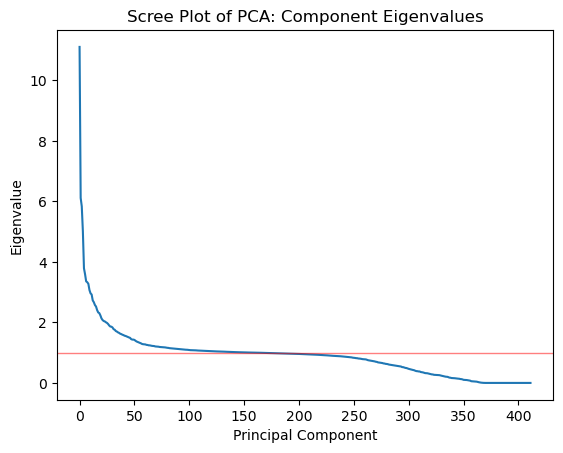

In [11]:
scree_plot()

In [12]:
next(x[0] for x in enumerate(pca.explained_variance_) if x[1] < 1)

160

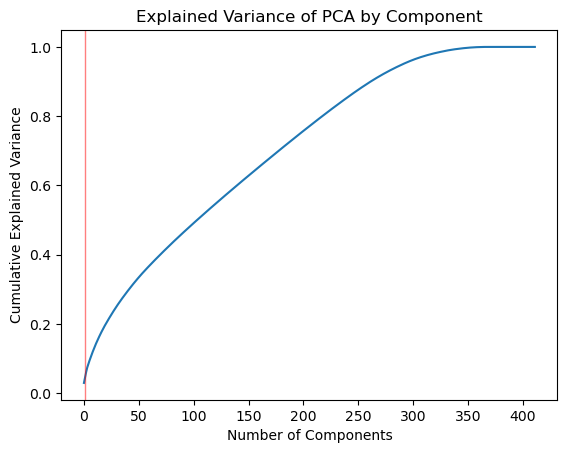

In [13]:
var_explained()

In [9]:
pca = PCA(n_components = 0.7)
pca.fit(normalised_dataset_kmeans)
pca_dataset_kmeans = pca.transform(normalised_dataset_kmeans)
pca_dataset_kmeans

array([[ 3.68797915, -2.16776793,  1.28435794, ...,  0.38538683,
        -0.82758985, -1.19983964],
       [ 2.00531864, -0.88606148, -4.32589375, ..., -0.21368971,
         1.0818338 , -0.88239824],
       [-2.04630418, -0.01979577,  1.65593291, ...,  0.78996908,
         0.9544978 , -0.31316498],
       ...,
       [ 3.49278461,  2.20478754, -0.79752744, ..., -0.28648198,
         0.38932578,  0.3022369 ],
       [-0.89755415, -0.47864203,  0.65588575, ...,  0.43114397,
         0.10942247, -0.10294266],
       [-1.44901193, -0.0974869 , -3.5358882 , ..., -0.1414098 ,
        -0.60176365, -0.06447163]])

In [10]:
pca_dataset_kmeans_df = pd.DataFrame(data = pca_dataset_kmeans)
pca_dataset_kmeans_dfpca_dataset_kmeans_df = pd.DataFrame(data = pca_dataset_kmeans)
pca_dataset_kmeans_df

0         1         2         3         4         5         6    \
0      3.687979 -2.167768  1.284358  2.086259 -1.921542  0.592158  1.108629   
1      2.005319 -0.886061 -4.325894 -1.519662 -1.593669  0.360185  1.940286   
2     -2.046304 -0.019796  1.655933  1.711399 -0.169355 -1.984046 -0.563813   
3     -0.604680 -1.080172  0.343439  2.334927 -1.691364 -0.137439 -2.508099   
4      0.403954  0.930385 -2.506430 -1.927867  2.854600 -3.537049  0.606847   
...         ...       ...       ...       ...       ...       ...       ...   
48739 -0.942735  4.615769 -0.858286 -3.125869  1.627998  2.199370 -1.561527   
48740  0.943332 -1.957179 -0.018316  1.292457  4.639474 -2.371282  0.098186   
48741  3.492785  2.204788 -0.797527  0.552486 -1.790887  1.411898  0.589968   
48742 -0.897554 -0.478642  0.655886  1.962973 -2.531322 -2.088331 -0.722776   
48743 -1.449012 -0.097487 -3.535888 -0.295091 -0.854613  1.160853  0.196551   

            7         8         9    ...       169       170       171  \
0      1.507212 -1.974143  1.748899  ...  0.064768  0.192841 -0.524010   
1      0.551015  0.294030 -0.133679  ...  0.500542  0.726401 -0.268198   
2     -0.387224  1.273756  0.136090  ...  1.486068  0.794918 -0.458940   
3      0.131700  1.591093  2.279289  ...  0.211700 -0.019855 -0.164252   
4     -1.444231  1.426440  0.889564  ... -0.011781 -0.028263 -0.474038   
...         ...       ...       ...  ...       ...       ...       ...   
48739 -1.839350 -9.973677 -0.767596  ... -2.250360  0.119925 -3.107369   
48740 -0.238215  0.918955  1.566568  ...  0.158093 -0.289304  0.266941   
48741  1.155005  0.802235  0.124707  ...  0.770087  0.315470 -0.576354   
48742 -1.594459 -1.308146  0.976502  ... -0.173465 -0.048330  0.012696   
48743 -1.306515  1.188140  1.539398  ... -0.278511 -0.820336  0.096338   

            172       173       174       175       176       177       178  
0     -0.713516 -0.544130 -0.557188  0.231708  0.385387 -0.827590 -1.199840  
1      0.514617 -0.075600 -0.993416 -0.605616 -0.213690  1.081834 -0.882398  
2     -1.393252  0.166362  0.165087  0.668150  0.789969  0.954498 -0.313165  
3      0.144476 -0.068890  0.309593 -0.373731  0.343551  0.246716 -0.018694  
4     -0.098002  0.158794 -0.034272 -0.281738 -0.002869 -0.534617  0.136175  
...         ...       ...       ...       ...       ...       ...       ...  
48739  3.666495 -4.243735  3.737613  3.148358  0.685667  1.444676  2.913460  
48740  0.122818  0.622062 -0.148582  0.222482  0.626330  0.250239 -0.868929  
48741 -0.249421 -0.040826 -0.374476  0.428929 -0.286482  0.389326  0.302237  
48742 -0.019191  0.547535  0.003479  0.261013  0.431144  0.109422 -0.102943  
48743  0.669943  0.407100  0.338609 -0.263216 -0.141410 -0.601764 -0.064472  

[48744 rows x 179 columns]

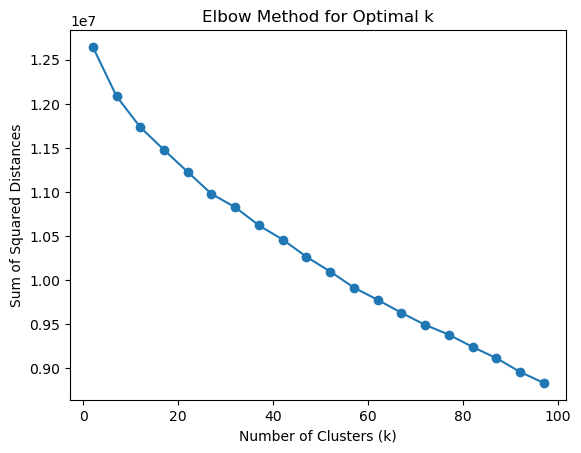

In [20]:
# Data
X = pca_dataset_kmeans_df

k_values = range(2, 101, 5)
# Calculate sum of squared distances for different values of k

sse = []
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(X, labels)
    silhouette_scores.append(silhouette_avg)
    sse.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.plot(k_values, sse, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.show()

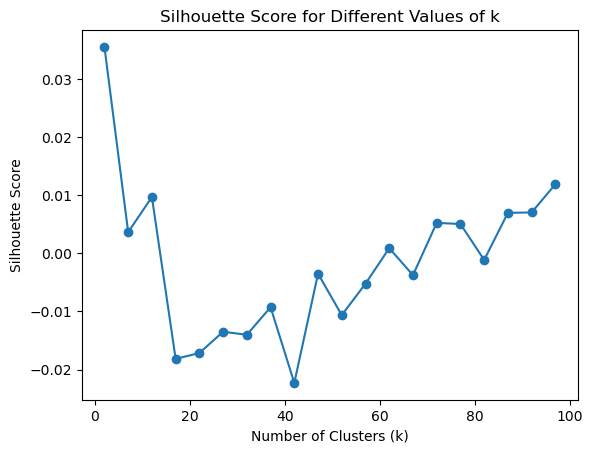

In [21]:
# Find the optimal number of clusters (k) with the highest silhouette score
optimal_k = k_values[silhouette_scores.index(max(silhouette_scores))]

# Plot the silhouette scores for different k values
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Values of k')
plt.show()

In [22]:
print(f"Optimal number of clusters (k): {optimal_k}")

Optimal number of clusters (k): 2


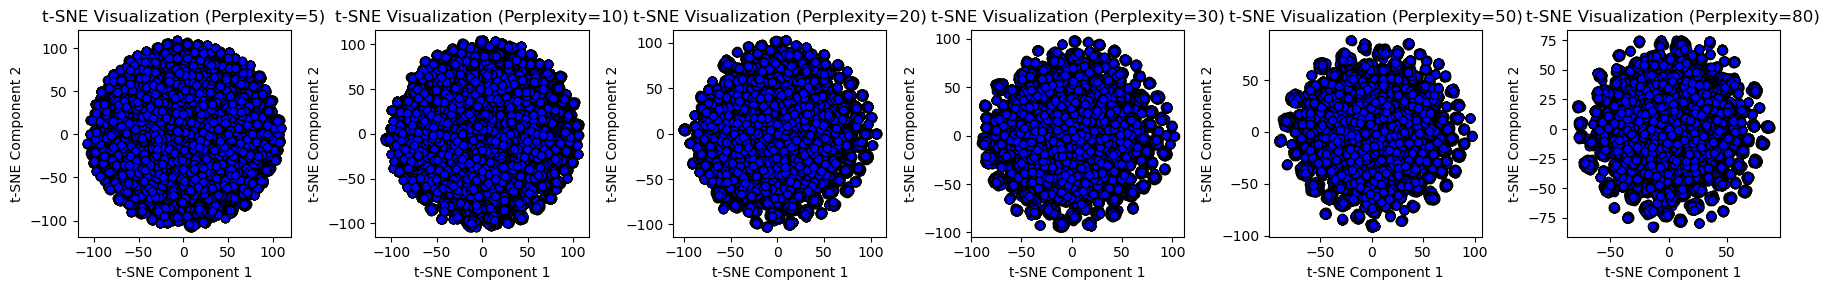

In [12]:
# Try different perplexity values
perplexity_values = [5, 10, 20, 30, 50, 80]
X = pca_dataset_kmeans_df

# Create subplots
plt.figure(figsize=(18, 3))

for i, perplexity in enumerate(perplexity_values, 1):
    # Apply t-SNE with different perplexity values
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    X_tsne = tsne.fit_transform(X)

    # Create a subplot
    plt.subplot(1, len(perplexity_values), i)

    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c='blue', marker='o', edgecolor='k')

    plt.title(f't-SNE Visualization (Perplexity={perplexity})')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')

plt.tight_layout()
plt.show()

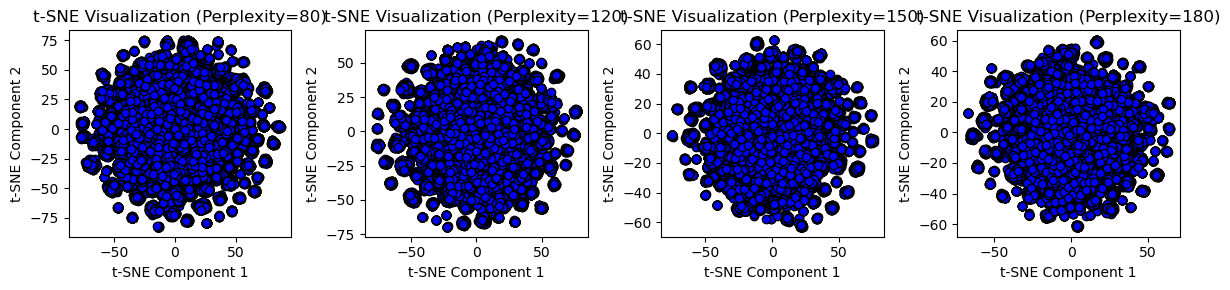

In [13]:
# Try different perplexity values
perplexity_values = [80, 120, 150, 180]
X = pca_dataset_kmeans_df

# Create subplots
plt.figure(figsize=(12, 3))

for i, perplexity in enumerate(perplexity_values, 1):
    # Apply t-SNE with different perplexity values
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    X_tsne = tsne.fit_transform(X)

    # Create a subplot
    plt.subplot(1, len(perplexity_values), i)

    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c='blue', marker='o', edgecolor='k')

    plt.title(f't-SNE Visualization (Perplexity={perplexity})')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')

plt.tight_layout()
plt.show()

In [15]:
tsne = TSNE(n_components=2, perplexity=80, random_state=42)
X_tsne = tsne.fit_transform(X)

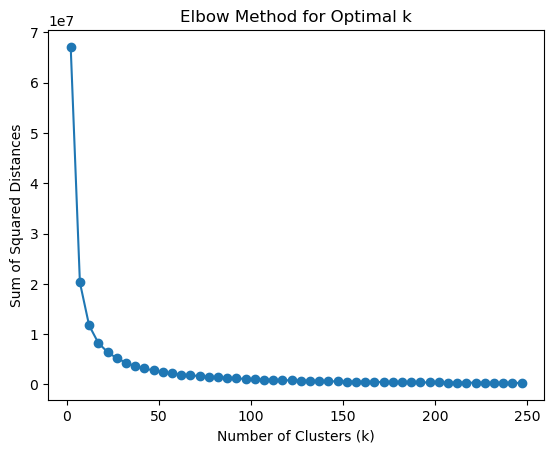

In [16]:
# Data
X = X_tsne

k_values = range(2, 250, 5)
# Calculate sum of squared distances for different values of k

sse = []
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(X, labels)
    silhouette_scores.append(silhouette_avg)
    sse.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.plot(k_values, sse, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.show()

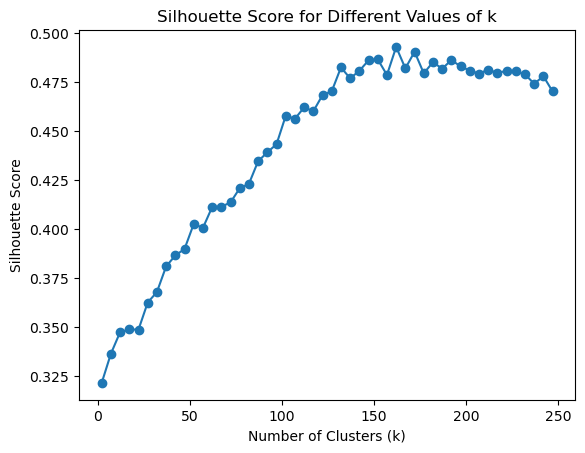

In [17]:
# Find the optimal number of clusters (k) with the highest silhouette score
optimal_k = k_values[silhouette_scores.index(max(silhouette_scores))]

# Plot the silhouette scores for different k values
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Values of k')
plt.show()

In [18]:
print(f"Optimal number of clusters (k): {optimal_k}")

Optimal number of clusters (k): 162


In [19]:
kmeans = KMeans(n_clusters=50, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(X)

KMeans(n_clusters=50, n_init=10, random_state=0)

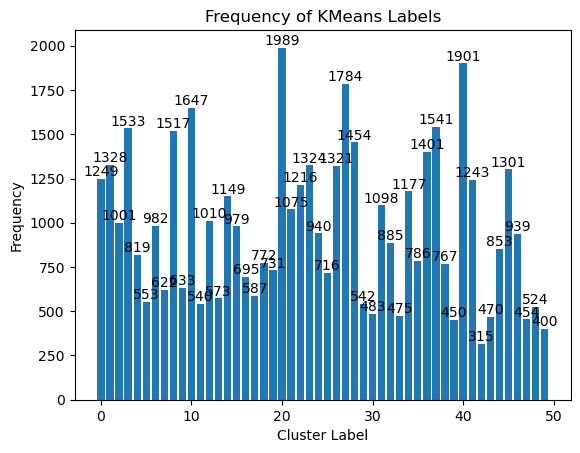

In [29]:
labels = kmeans.labels_
num_clusters = 50

label_counts = {label: sum(labels == label) for label in range(num_clusters)}

# Plot the bar plot with frequencies displayed above each bar
fig, ax = plt.subplots()
bars = ax.bar(range(num_clusters), label_counts.values())

# Display frequencies above each bar
for bar, count in zip(bars, label_counts.values()):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, round(count, 2), ha='center', va='bottom')

plt.title('Frequency of KMeans Labels')
plt.xlabel('Cluster Label')
plt.ylabel('Frequency')
plt.show()

In [32]:
ss = silhouette_score(X, labels)
print(f"Silhouette score for 50 clusters : {ss}")

Silhouette score for 50 clusters : 0.39127737283706665
